# Data loading

In [1]:
import itertools
import random
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

from ev_simulation_model.data import load_norway_residential_data
from ev_simulation_model.models import MultivariateNormal

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
plt.rcParams["figure.dpi"] = 100
sns.set_style("whitegrid")
sns.set_context("notebook")

In [2]:
CWD = Path("/Users/phipag/Git/powertac/ev-simulation-model")

In [3]:
raw_df = load_norway_residential_data(CWD / "data" / "norway_residential" / "Dataset 1_EV charging reports.csv")

# Density estimation

## Exploring the densities

In [4]:
density_df = raw_df[["Duration_hours", "El_kWh", "Start_plugin_hour"]]
density_df

Duration_hours  El_kWh  Start_plugin_hour
0           0.050000    0.30                 10
1           0.136667    0.87                 10
2           8.216389   29.87                 11
3          24.419722   15.56                 16
4           0.970556    3.62                 22
...              ...     ...                ...
6873        4.530000   13.43                 17
6874        3.182222    9.10                 18
6875        1.203889    4.28                 19
6876        0.352500    2.31                 19
6877        3.184167   20.14                 20

[6878 rows x 3 columns]

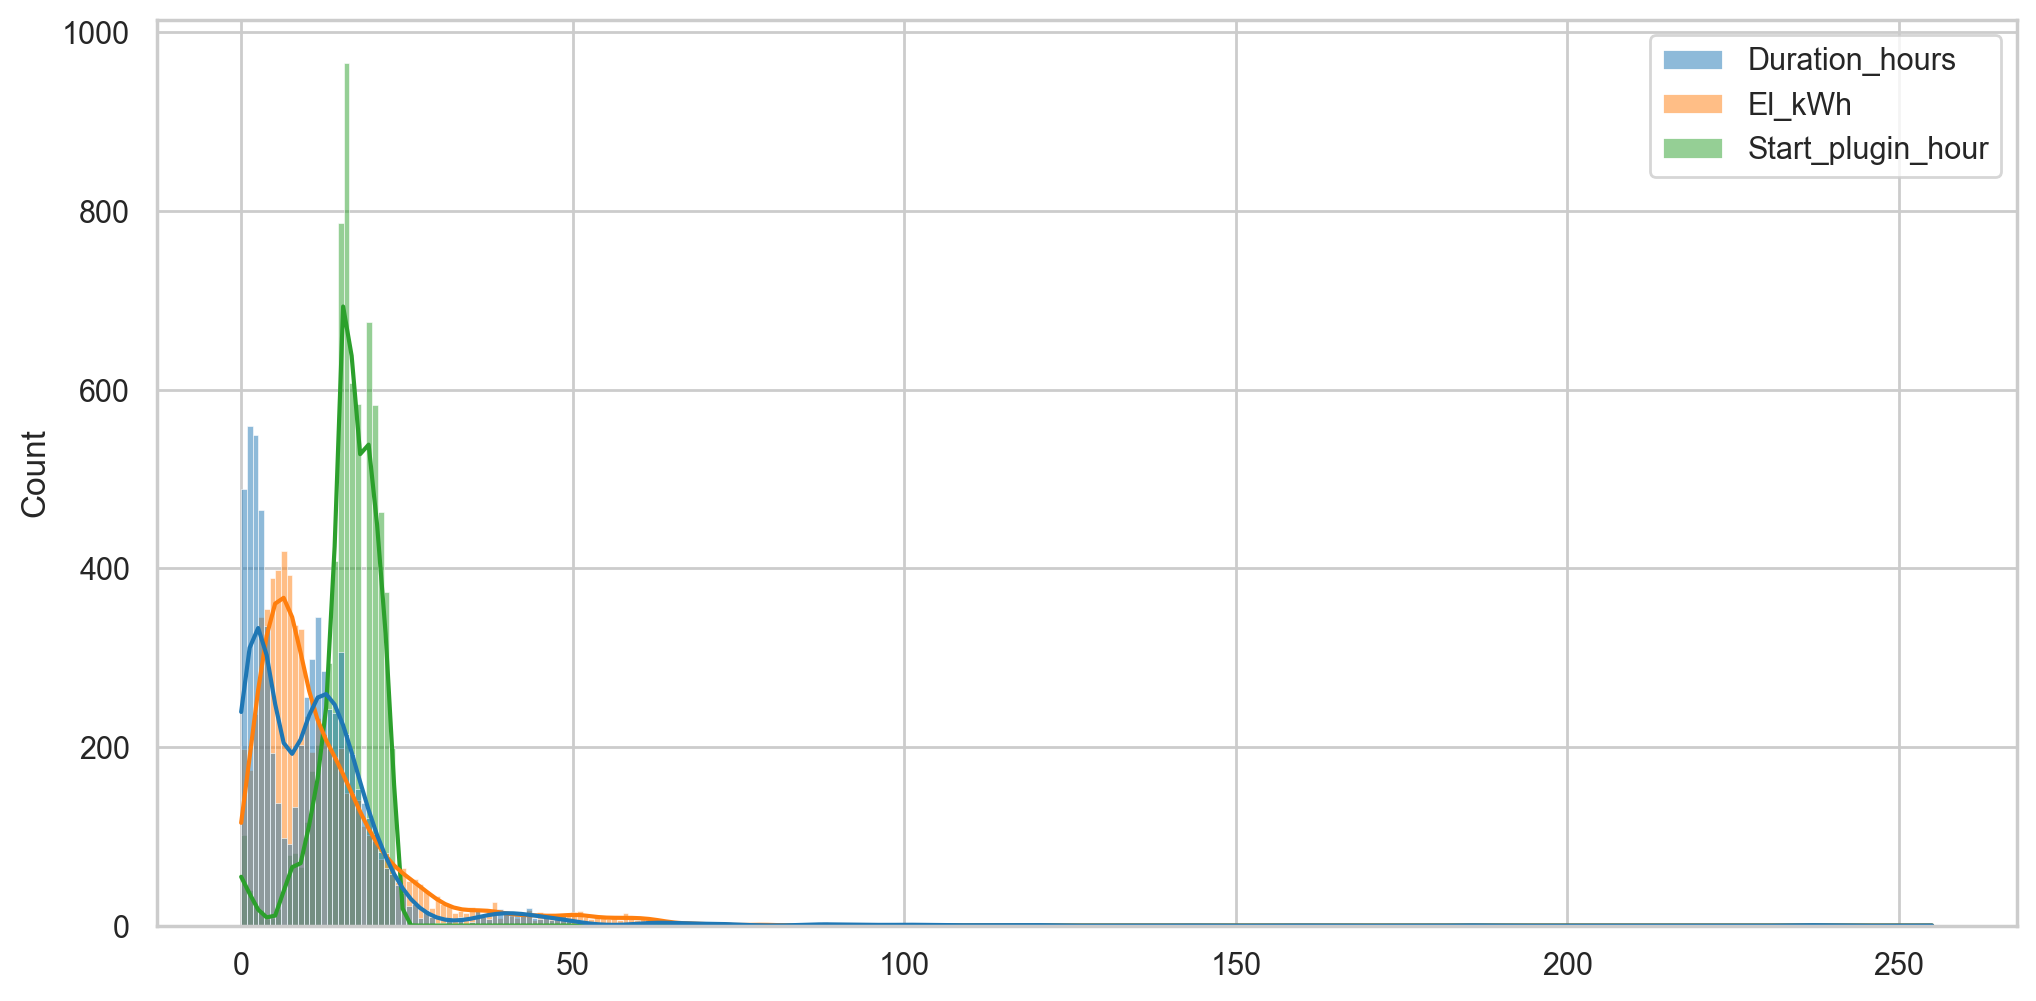

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(density_df, kde=True, ax=ax);

Let's remove the outliers in `Duration_hours` and `El_kWh` first by filtering out datapoints with a `zscore < 3`.

In [6]:
density_df = density_df[
    (density_df["Duration_hours"] - density_df["Duration_hours"].mean()) / density_df["Duration_hours"].std(ddof=0) < 3
].copy()
density_df = density_df[
    (density_df["El_kWh"] - density_df["El_kWh"].mean()) / density_df["El_kWh"].std(ddof=0) < 3
].copy()
density_df

Duration_hours  El_kWh  Start_plugin_hour
0           0.050000    0.30                 10
1           0.136667    0.87                 10
2           8.216389   29.87                 11
3          24.419722   15.56                 16
4           0.970556    3.62                 22
...              ...     ...                ...
6873        4.530000   13.43                 17
6874        3.182222    9.10                 18
6875        1.203889    4.28                 19
6876        0.352500    2.31                 19
6877        3.184167   20.14                 20

[6544 rows x 3 columns]

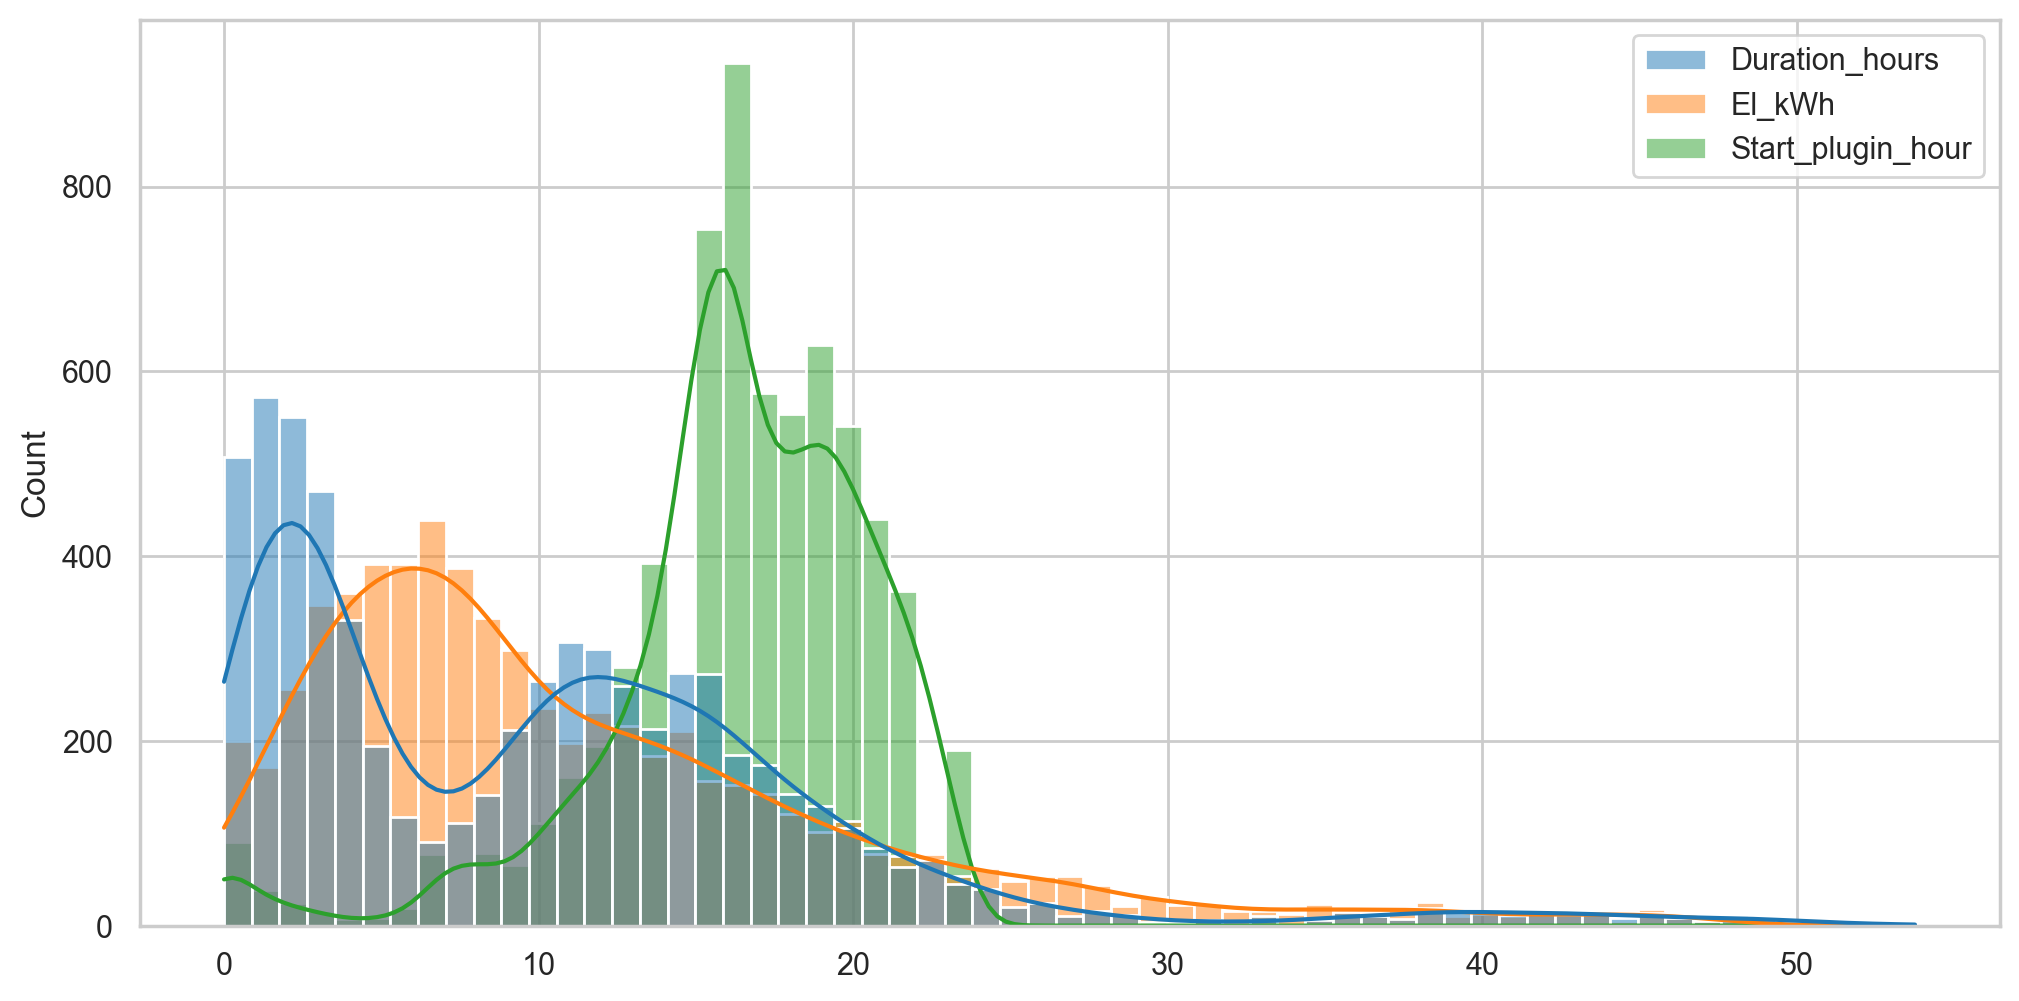

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(density_df, kde=True, ax=ax);

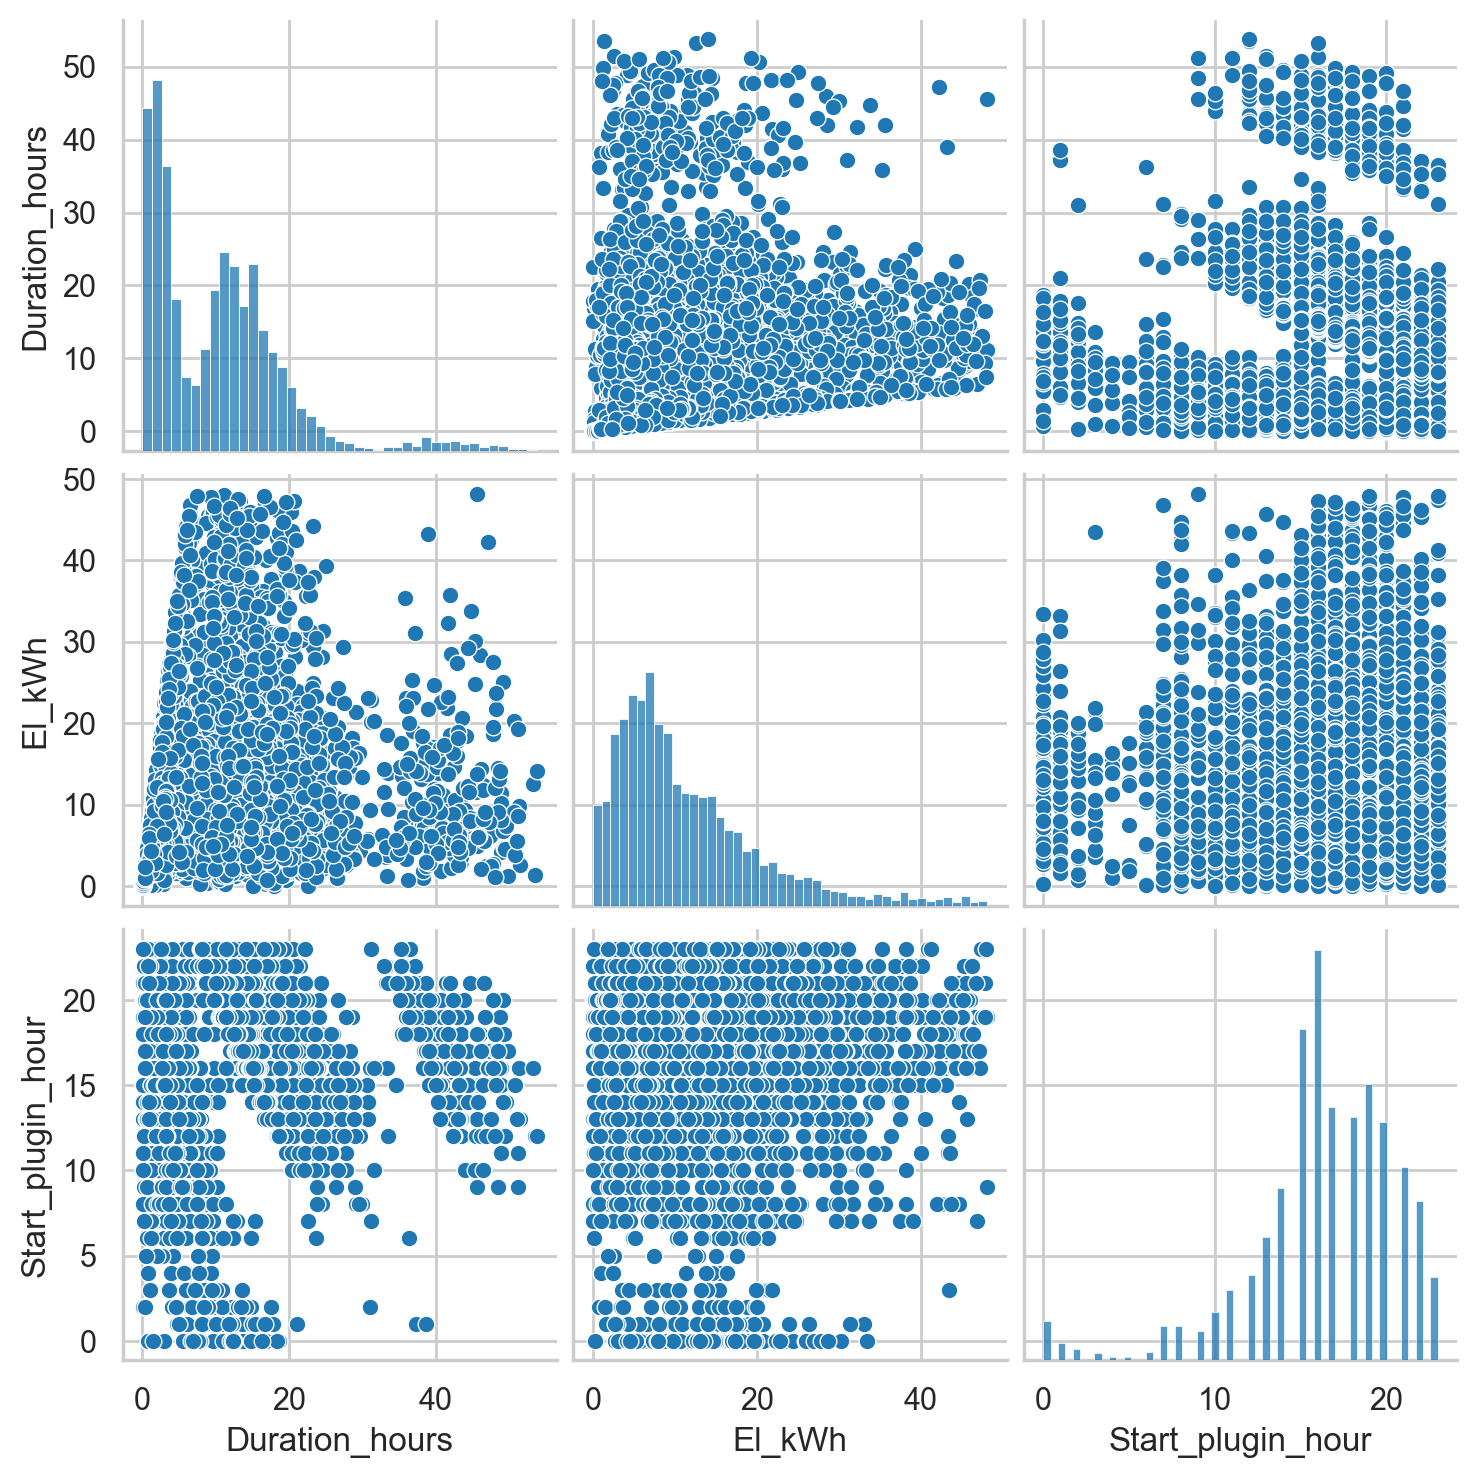

In [8]:
sns.pairplot(data=density_df, diag_kind="hist");

## Estimating the densities with a Gaussian Mixture Model

In [9]:
density_gmm_df = density_df.copy()

In [10]:
lowest_bic = np.infty
bics = []
n_components_range = range(1, 20)
cov_types = ["spherical", "tied", "diag", "full"]
for cov_type in cov_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=0)
        gmm.fit(density_gmm_df)
        bics.append(gmm.bic(density_gmm_df))
        if bics[-1] < lowest_bic:
            lowest_bic = bics[-1]
# Deleting last gmm variable to void confusion
del gmm

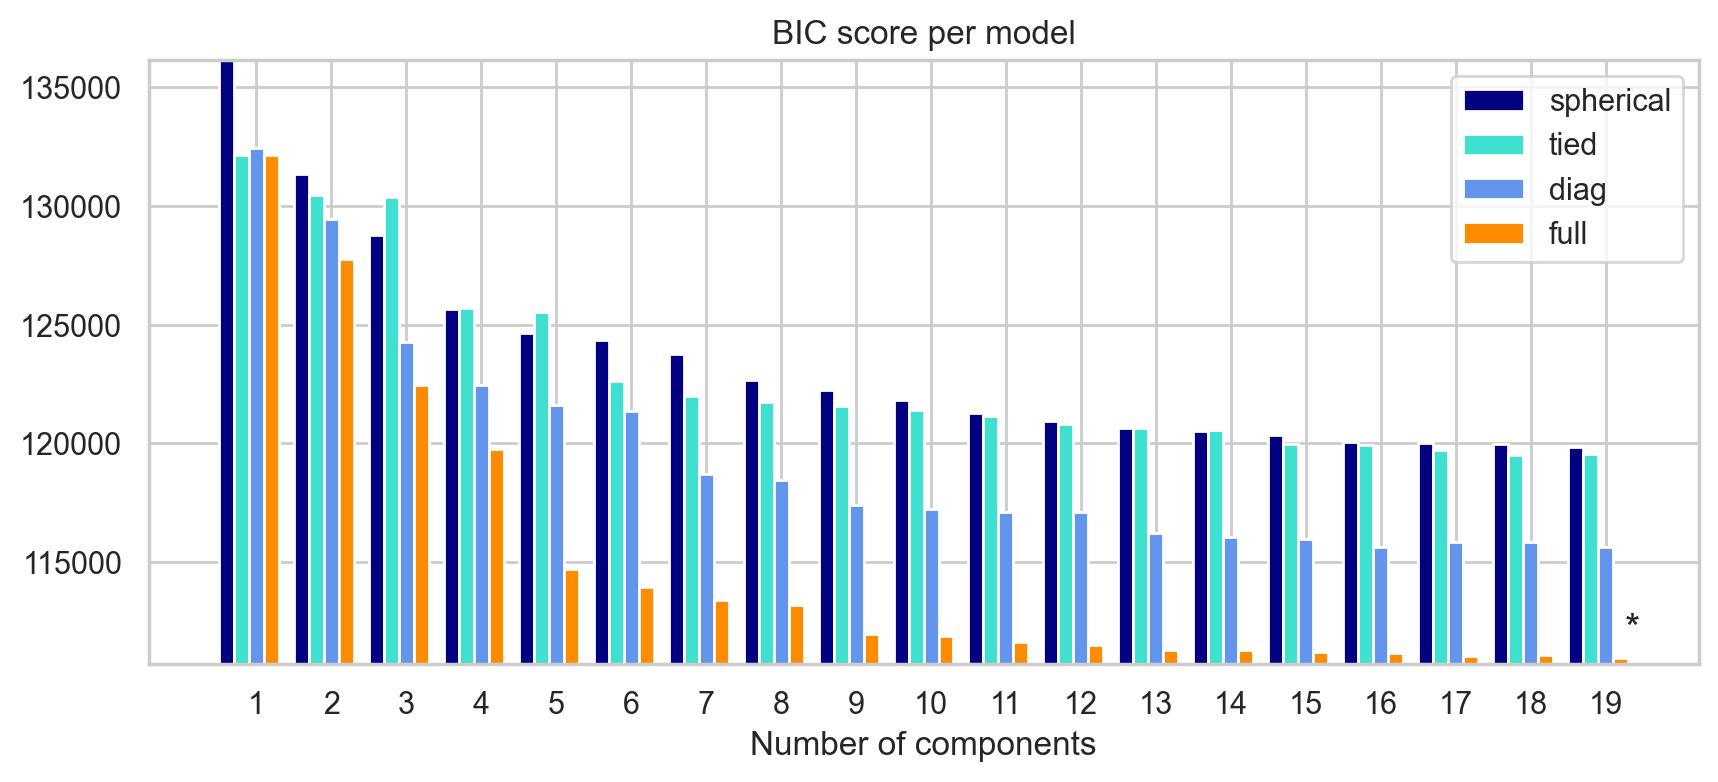

In [11]:
bics = np.array(bics)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
bars = []

plt.figure(figsize=(10, 4))
spl = plt.subplot(1, 1, 1)
for i, (cov_type, color) in enumerate(zip(cov_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bics[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bics.min() * 1.01 - 0.01 * bics.max(), bics.max()])
plt.title("BIC score per model")
xpos = np.mod(bics.argmin(), len(n_components_range)) + 0.65 + 0.2 * np.floor(bics.argmin() / len(n_components_range))
plt.text(xpos, bics.min() * 0.97 + 0.03 * bics.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cov_types)

In [12]:
best_gmm = GaussianMixture(n_components=5, covariance_type="full", random_state=0)
density_gmm_df["cluster"] = best_gmm.fit_predict(density_df)

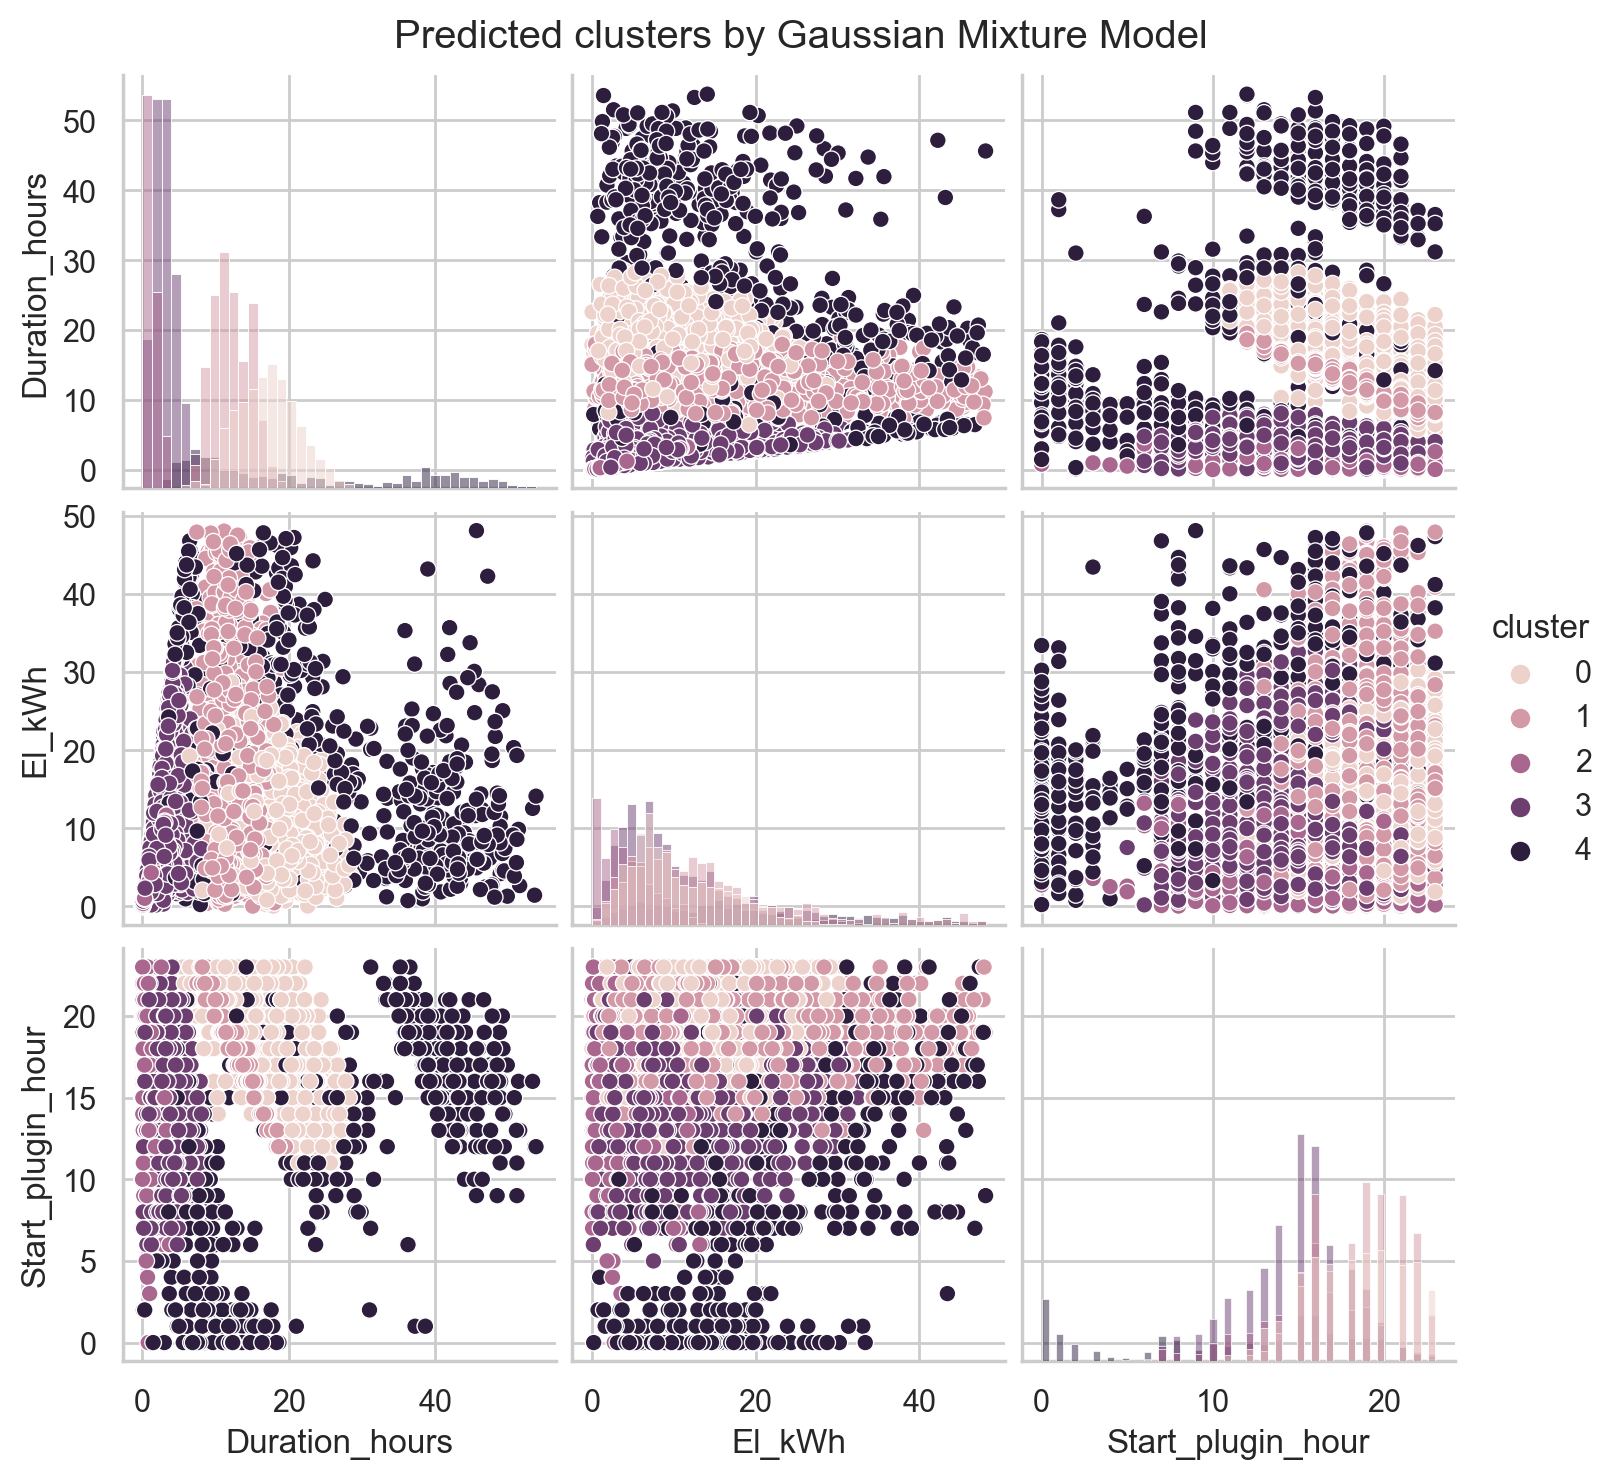

In [13]:
grid = sns.pairplot(data=density_gmm_df, hue="cluster", diag_kind="hist")
grid.figure.suptitle("Predicted clusters by Gaussian Mixture Model")
grid.tight_layout();

## Generating data from the fitted mixture distributions
This is the joint mixture distribution $p(\text{Duration_hours}, \text{El_kWh}, \text{Start_plugin_hour})$

In [14]:
samples, clusters = best_gmm.sample(len(density_df))
density_generated_df = pd.DataFrame(samples, columns=density_df.columns)
density_generated_df["cluster"] = clusters

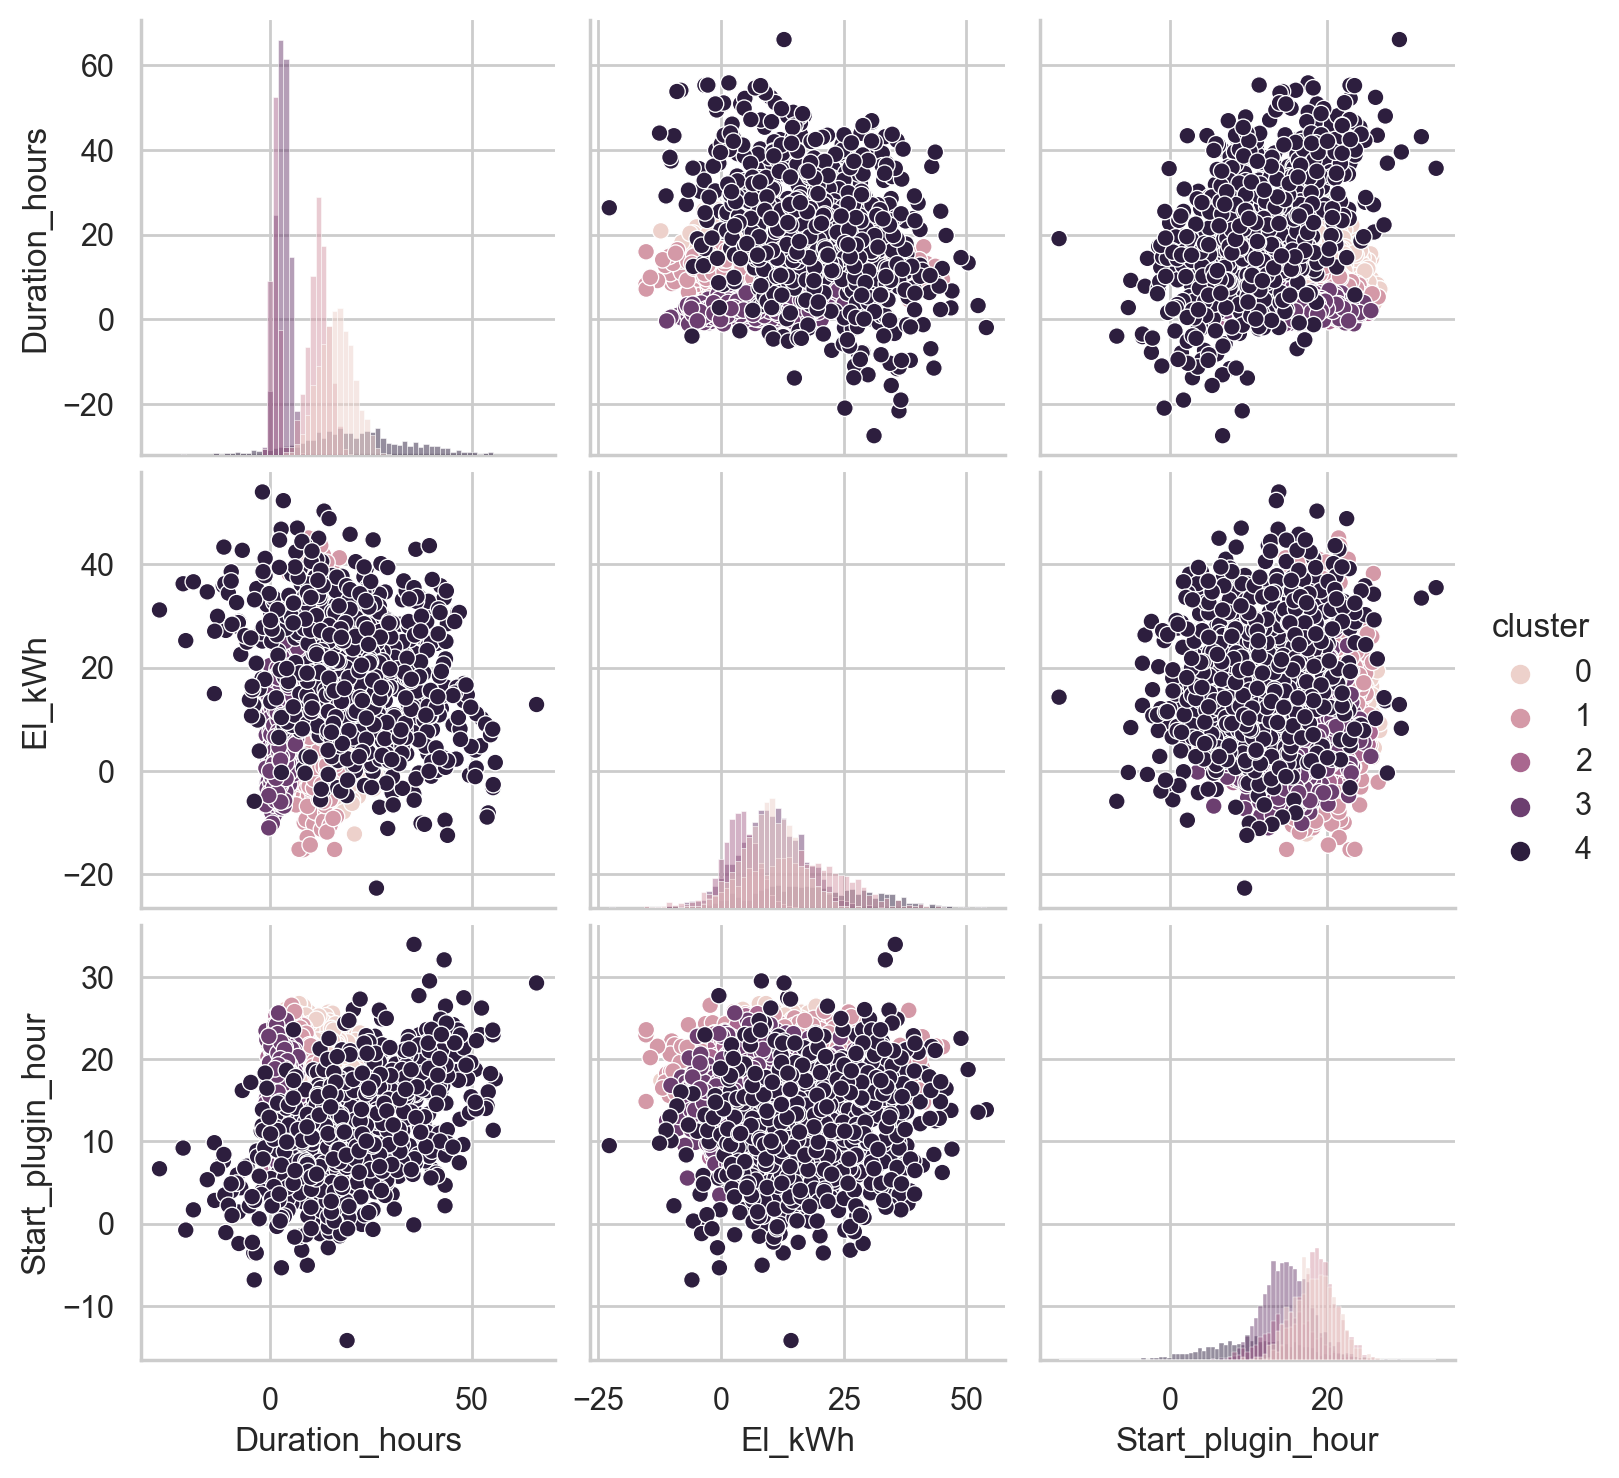

In [15]:
sns.pairplot(data=density_generated_df, hue="cluster", diag_kind="hist");

In [16]:
best_gmm.means_

array([[16.27807559, 10.31377236, 18.43250934],
       [12.18176491, 14.77768893, 18.80089312],
       [ 1.15435747,  4.12474982, 15.55221238],
       [ 3.07565393, 10.02363117, 14.90291084],
       [21.4811639 , 18.73971581, 11.54061503]])

In [17]:
best_gmm.covariances_

array([[[ 1.87081887e+01, -4.15188229e+00, -8.20127096e+00],
        [-4.15188229e+00,  3.38159314e+01,  3.73923506e+00],
        [-8.20127096e+00,  3.73923506e+00,  8.18433728e+00]],

       [[ 6.36278929e+00,  5.80137105e-01, -5.99239467e+00],
        [ 5.80137105e-01,  1.03502991e+02, -3.50890884e-01],
        [-5.99239467e+00, -3.50890884e-01,  6.03992805e+00]],

       [[ 7.77495585e-01,  2.80003561e+00, -4.49958574e-02],
        [ 2.80003561e+00,  1.00921998e+01, -1.52154721e-01],
        [-4.49958574e-02, -1.52154721e-01,  1.14469990e+01]],

       [[ 2.41230621e+00,  3.97291476e+00, -6.87083119e-01],
        [ 3.97291476e+00,  4.50052965e+01,  1.25861745e+00],
        [-6.87083119e-01,  1.25861745e+00,  9.13979493e+00]],

       [[ 2.11243085e+02, -6.19700421e+01,  5.15416293e+01],
        [-6.19700421e+01,  1.43581785e+02,  1.77586092e+01],
        [ 5.15416293e+01,  1.77586092e+01,  4.75771899e+01]]])

In [18]:
best_gmm.weights_

array([0.24367744, 0.2214327 , 0.13820255, 0.27830932, 0.11837799])

## Compare generated data with sample data

In [19]:
density_gen_vs_sample_df = pd.concat(
    [density_generated_df[["Duration_hours", "El_kWh"]], density_df[["Duration_hours", "El_kWh"]]], axis=1
)
density_gen_vs_sample_df.columns = [
    "Duration hours (generated)",
    "Electricity demand (generated)",
    "Duration hours (true sample)",
    "Electricity demand (true sample)",
]

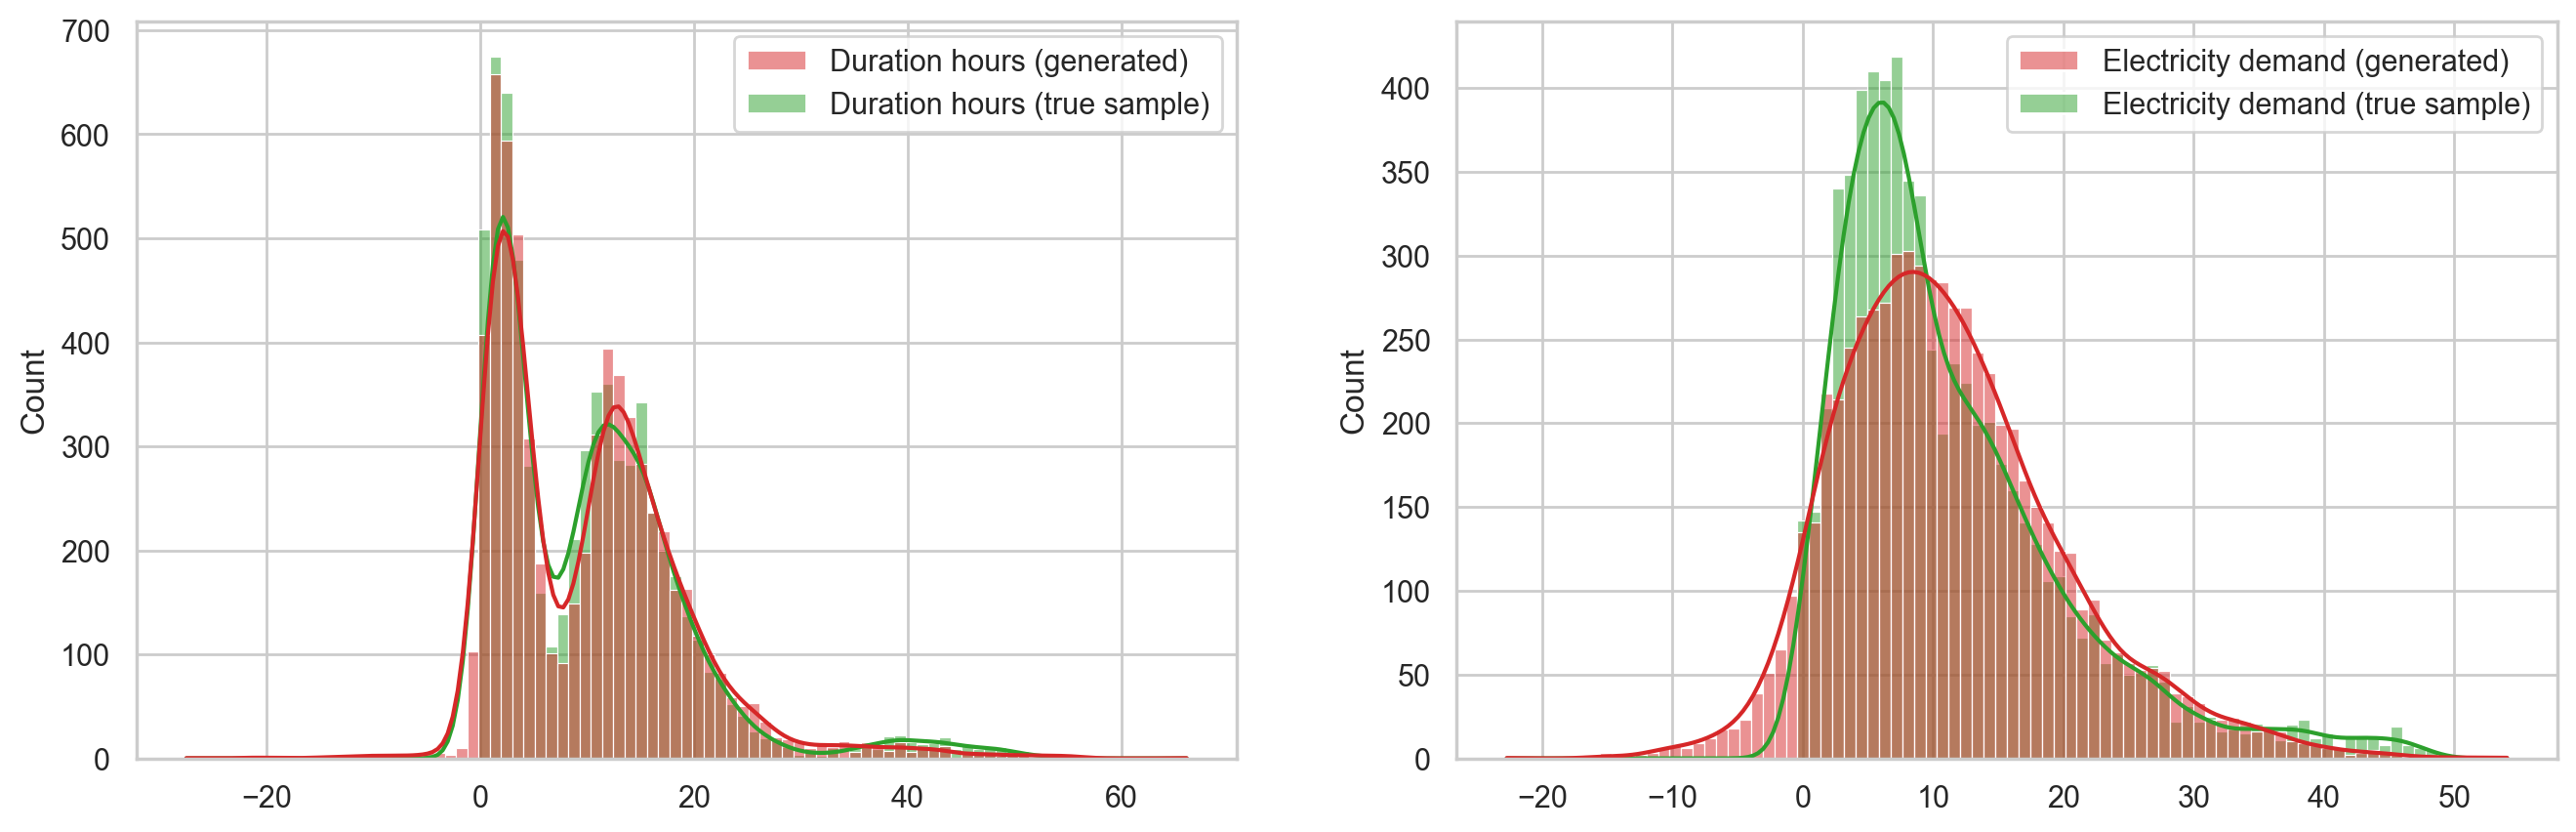

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.histplot(
    density_gen_vs_sample_df[["Duration hours (generated)", "Duration hours (true sample)"]],
    kde=True,
    palette=["#d62728", "#2ca02c"],
    ax=ax1,
)
sns.histplot(
    density_gen_vs_sample_df[["Electricity demand (generated)", "Electricity demand (true sample)"]],
    kde=True,
    palette=["#d62728", "#2ca02c"],
    ax=ax2,
);

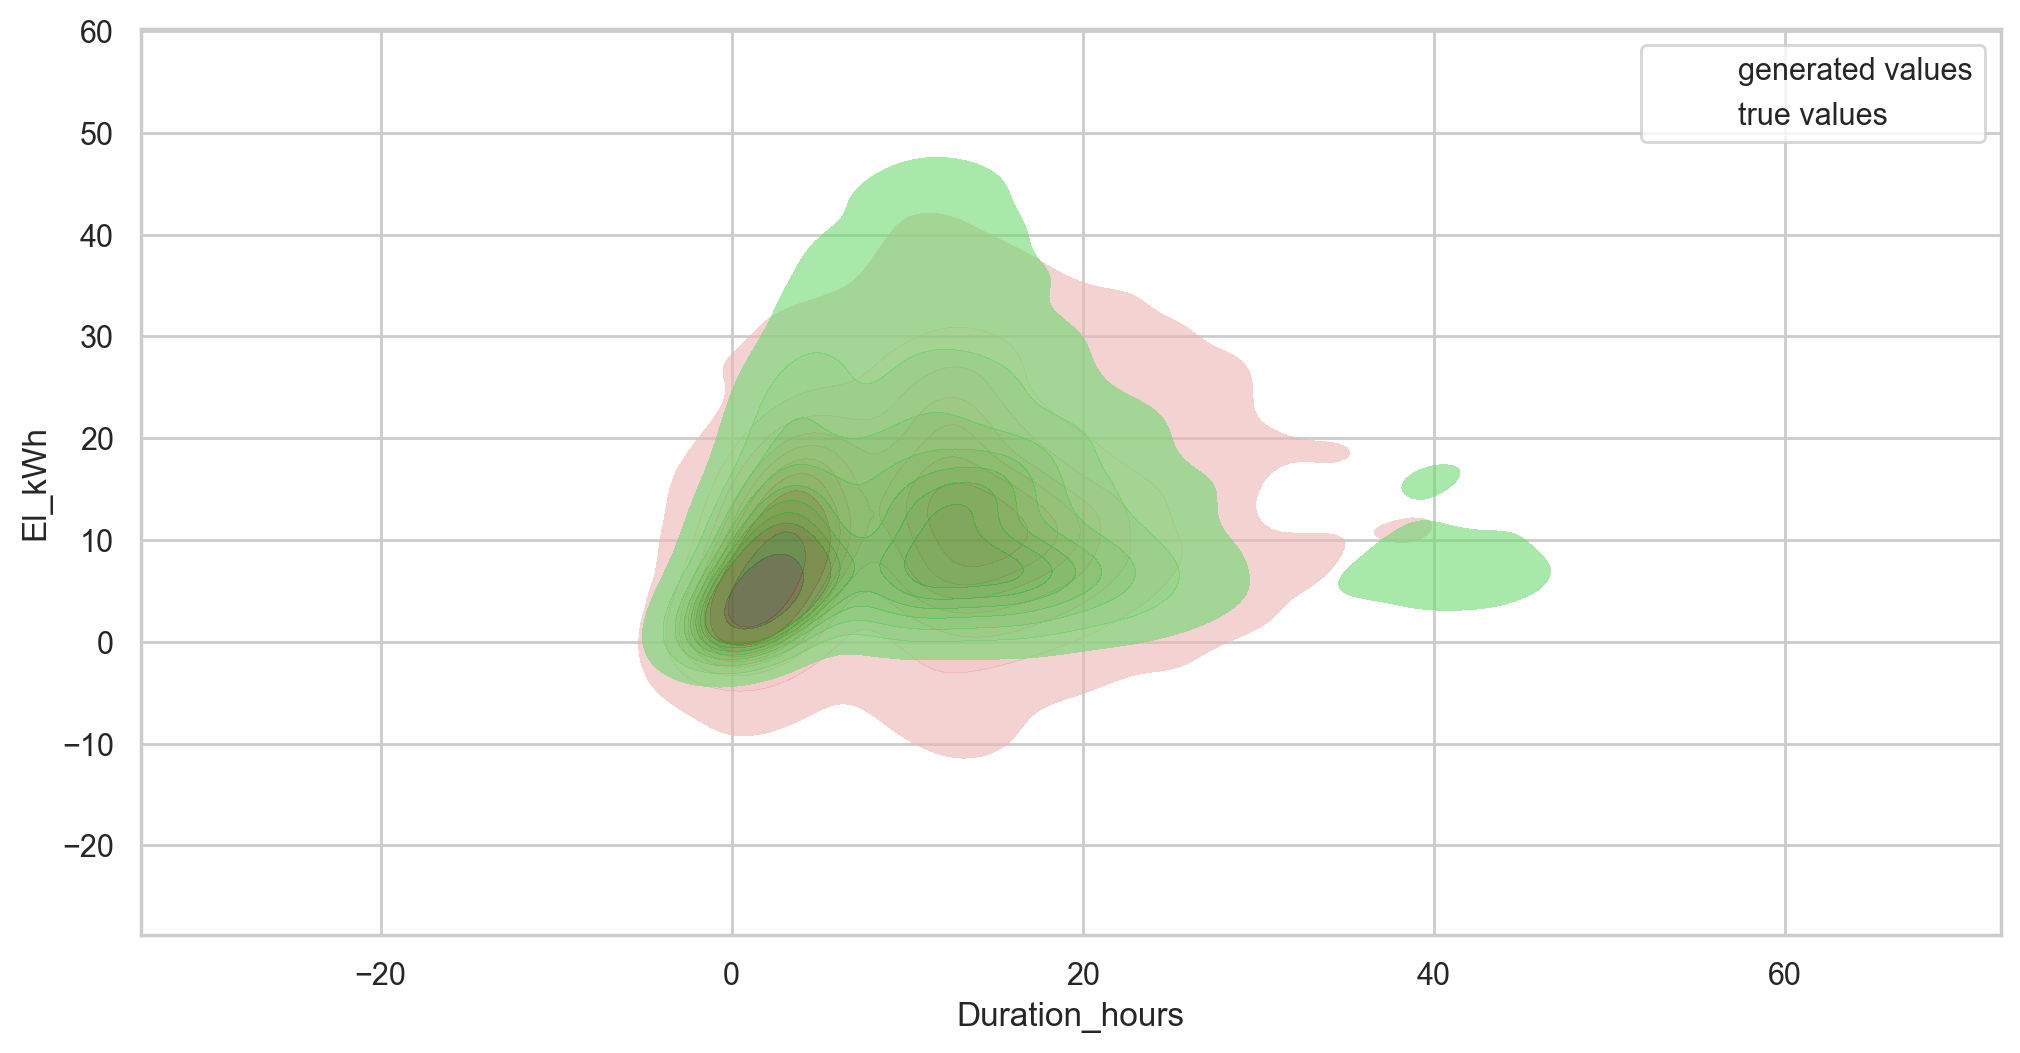

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
generated_kde = sns.kdeplot(
    data=density_generated_df,
    x="Duration_hours",
    y="El_kWh",
    shade=True,
    color="#d62728",
    alpha=0.6,
    label="generated values",
    ax=ax,
)
true_kde = sns.kdeplot(
    data=density_df, x="Duration_hours", y="El_kWh", shade=True, color="#2ca02c", alpha=0.6, label="true values", ax=ax
)
ax.legend();

## Conditional distribution $p(\text{Duration_hours}, \text{El_kWh} | \text{Start_plugin_hour})$

### True conditional distributions

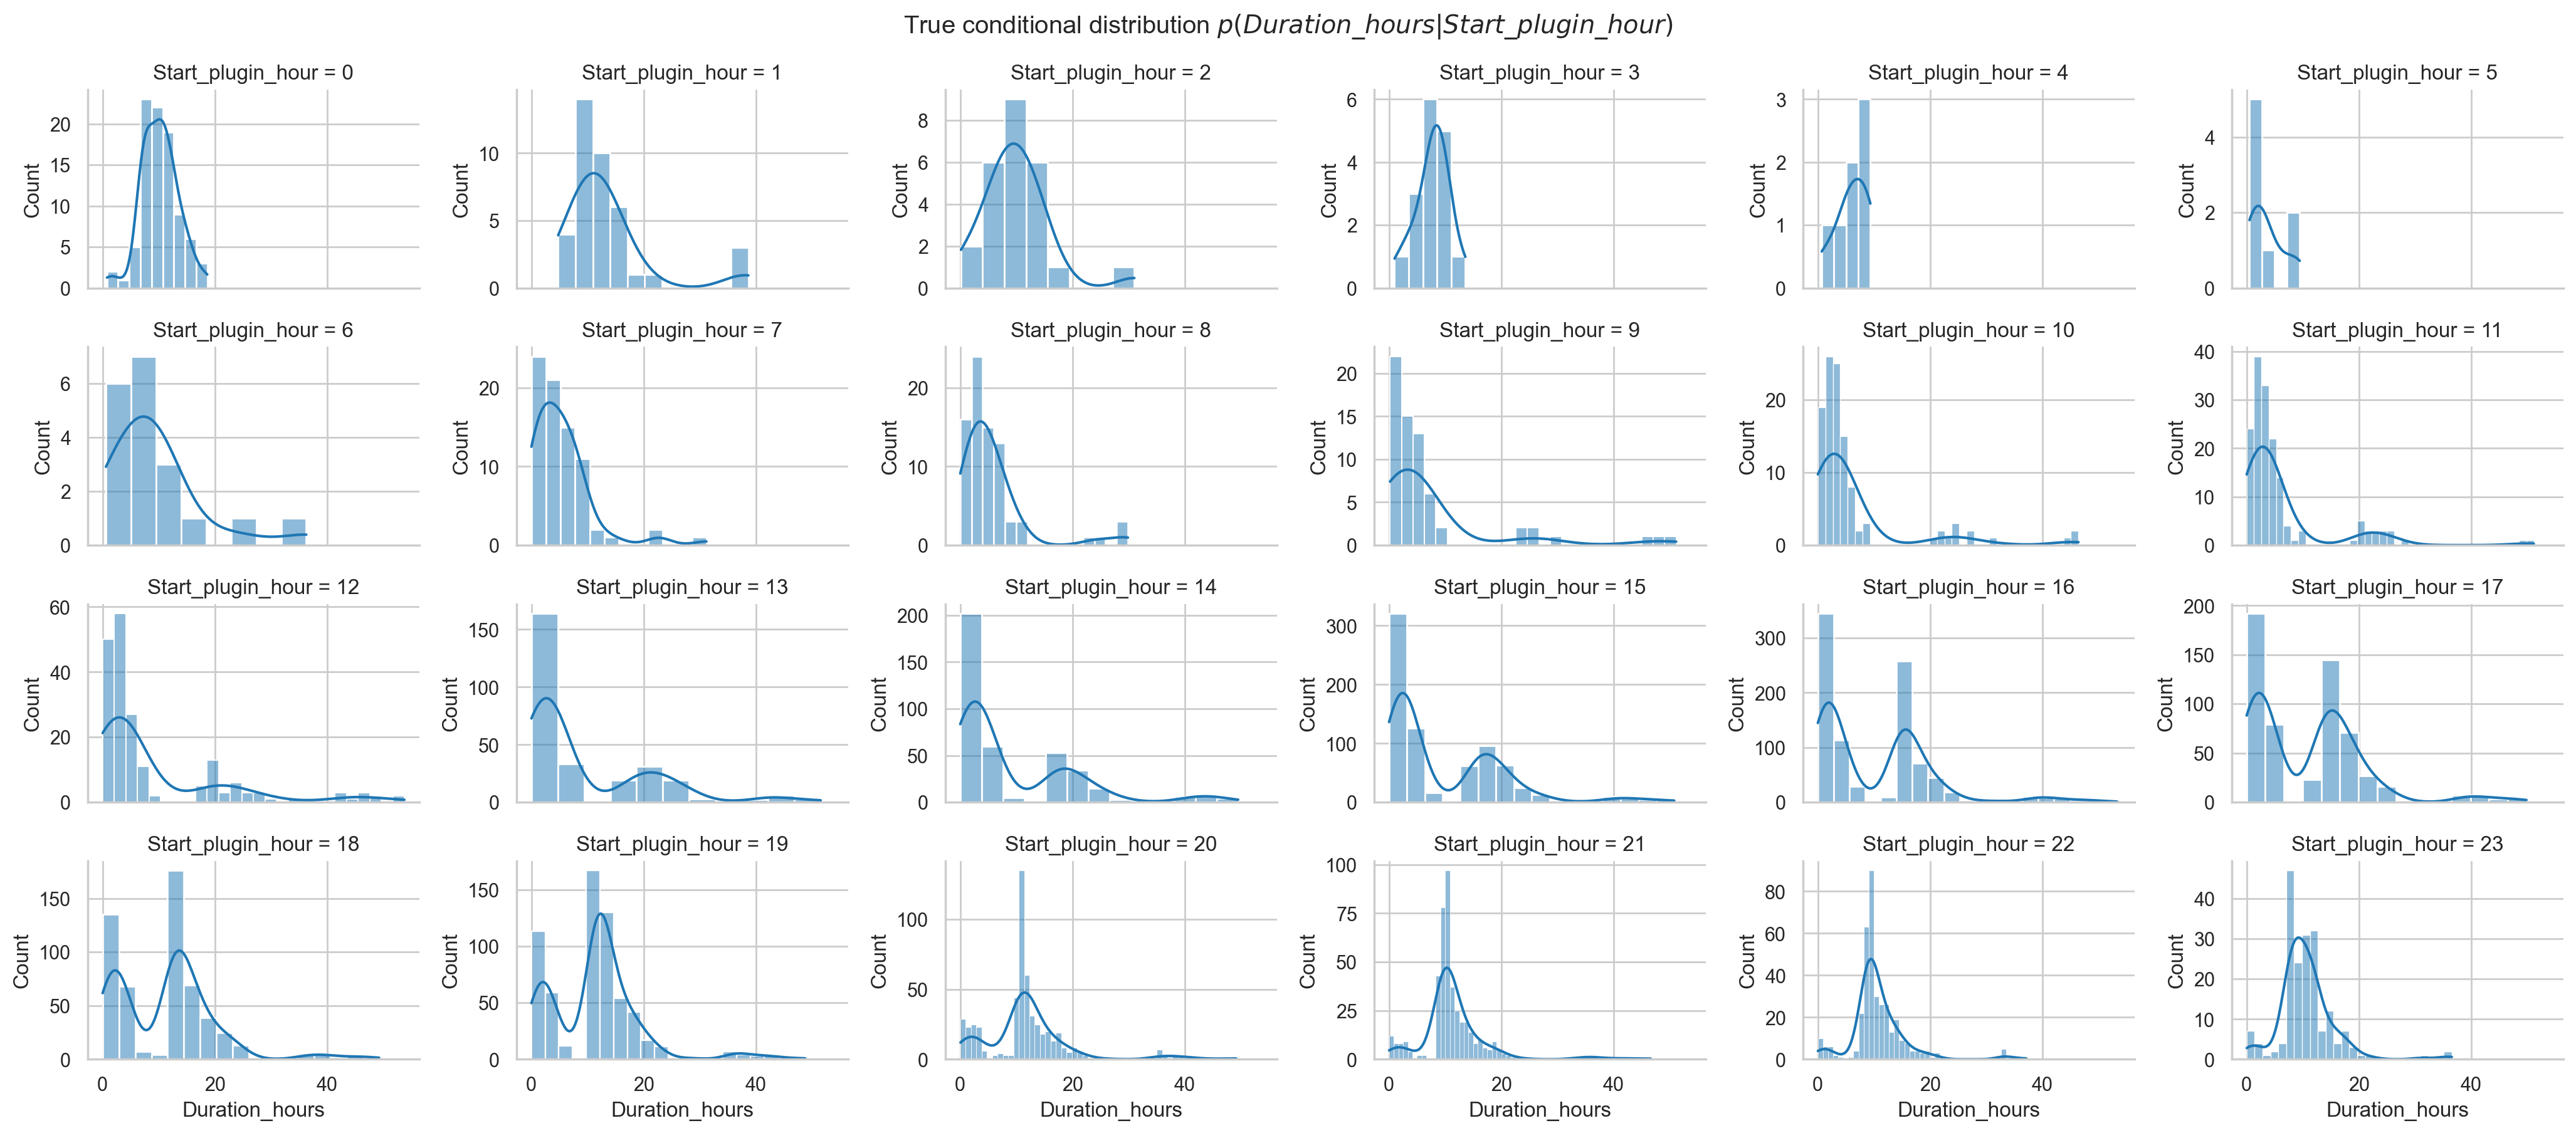

In [22]:
g = sns.FacetGrid(
    density_df,
    col="Start_plugin_hour",
    col_wrap=6,
    height=2.3,
    aspect=1.5,
    sharey=False,
)
g.map(sns.histplot, "Duration_hours", kde=True)
g.figure.suptitle(r"True conditional distribution $p(Duration\_hours | Start\_plugin\_hour)$")
g.figure.tight_layout();

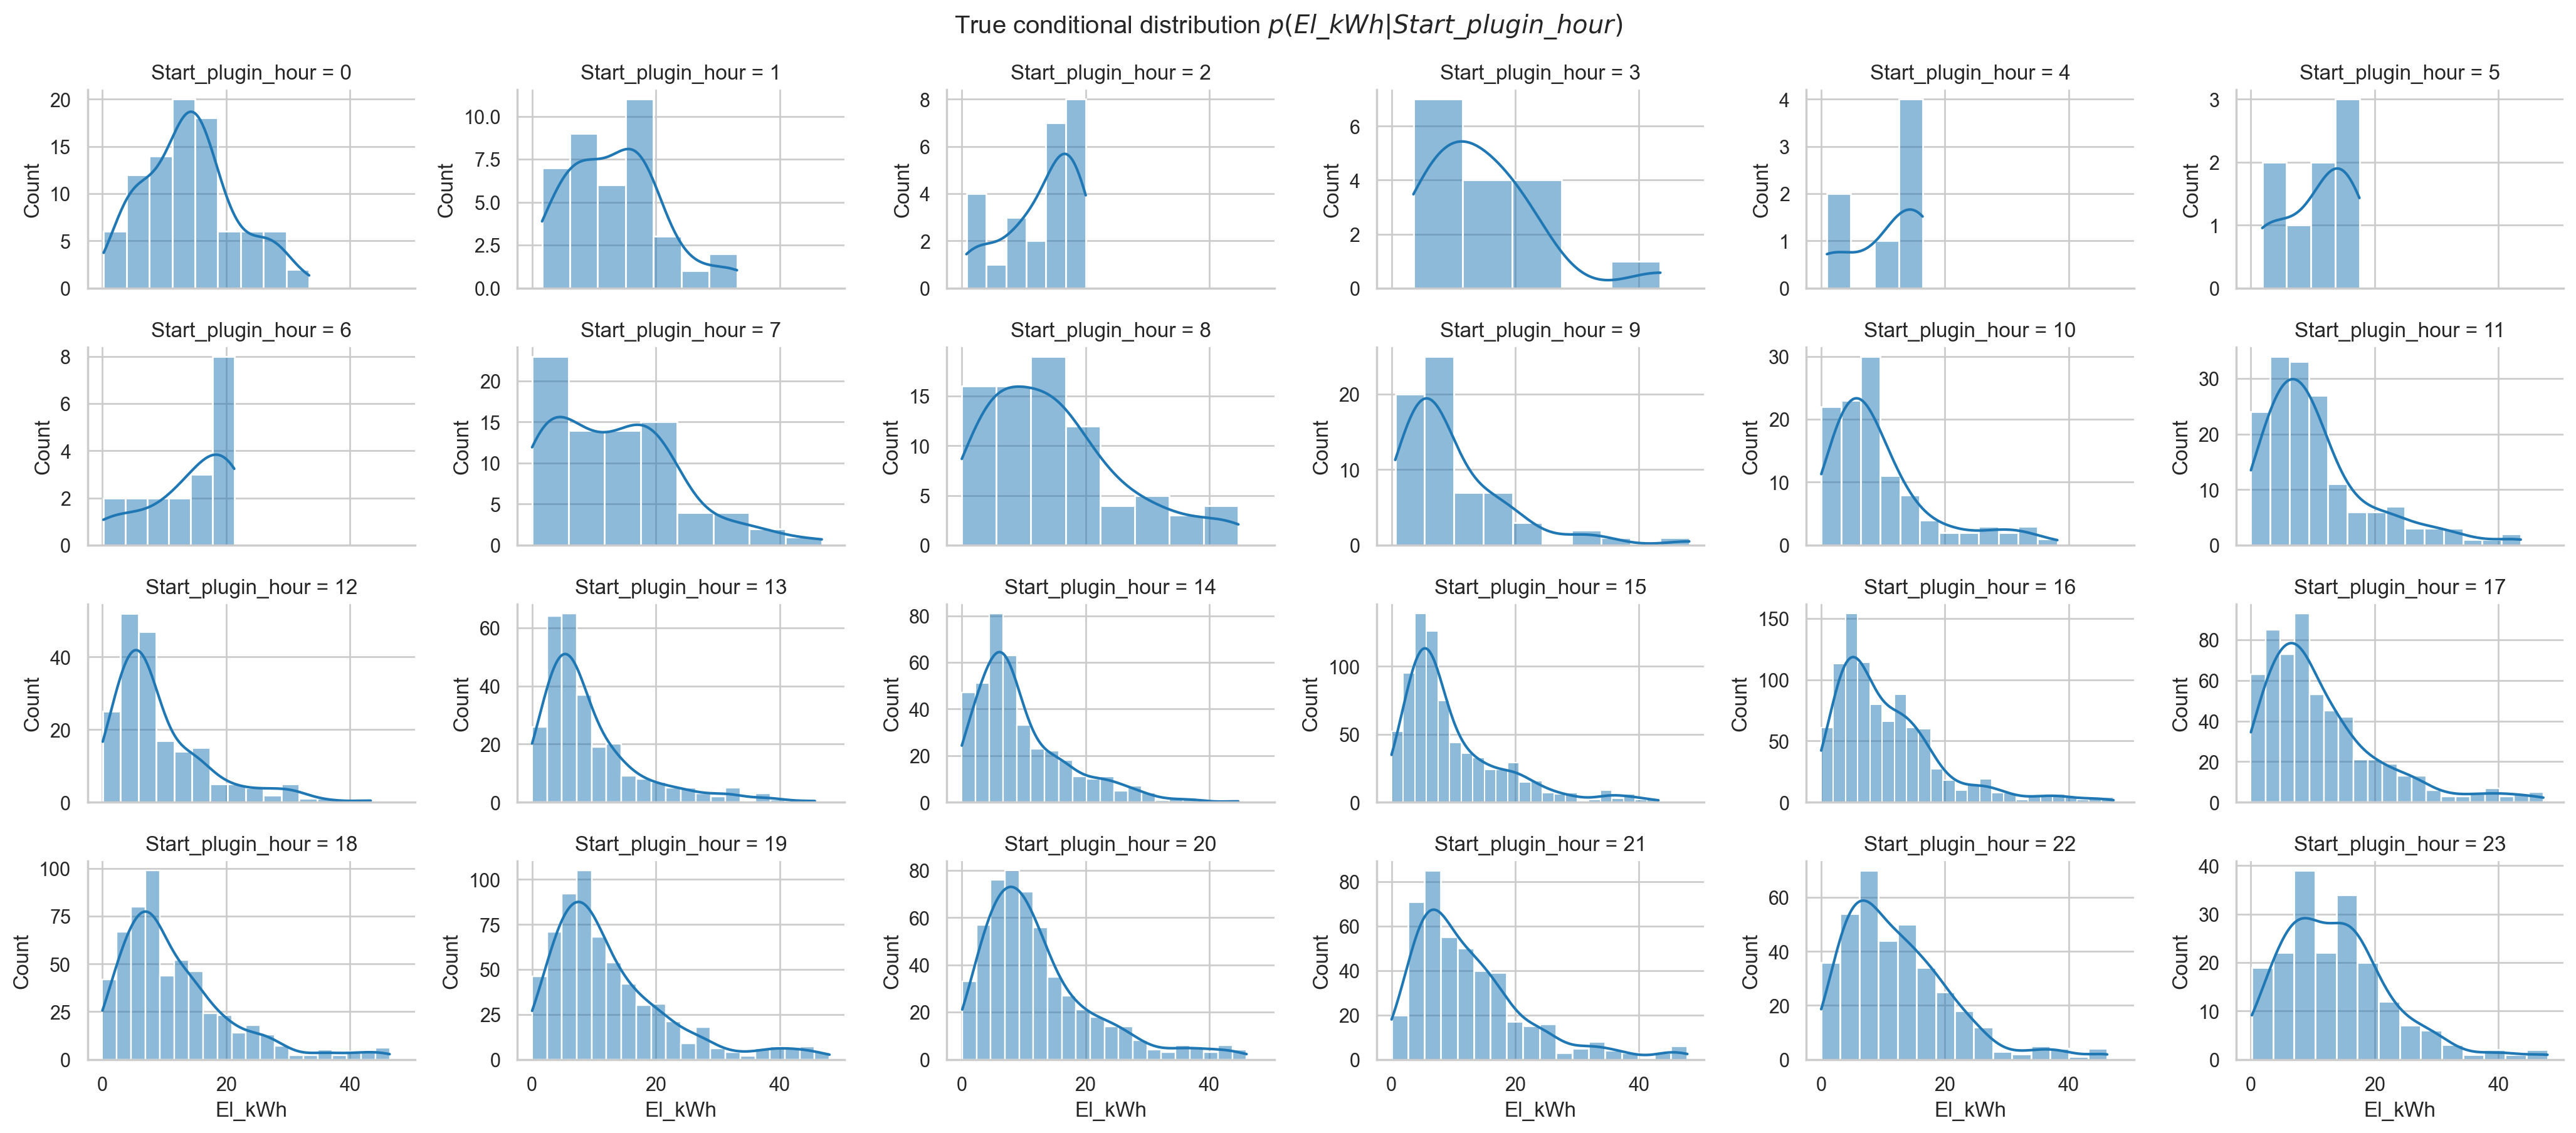

In [23]:
g = sns.FacetGrid(
    density_df,
    col="Start_plugin_hour",
    col_wrap=6,
    height=2.3,
    aspect=1.5,
    sharey=False,
)
g.map(sns.histplot, "El_kWh", kde=True)
g.figure.suptitle(r"True conditional distribution $p(El\_kWh | Start\_plugin\_hour)$")
g.figure.tight_layout();

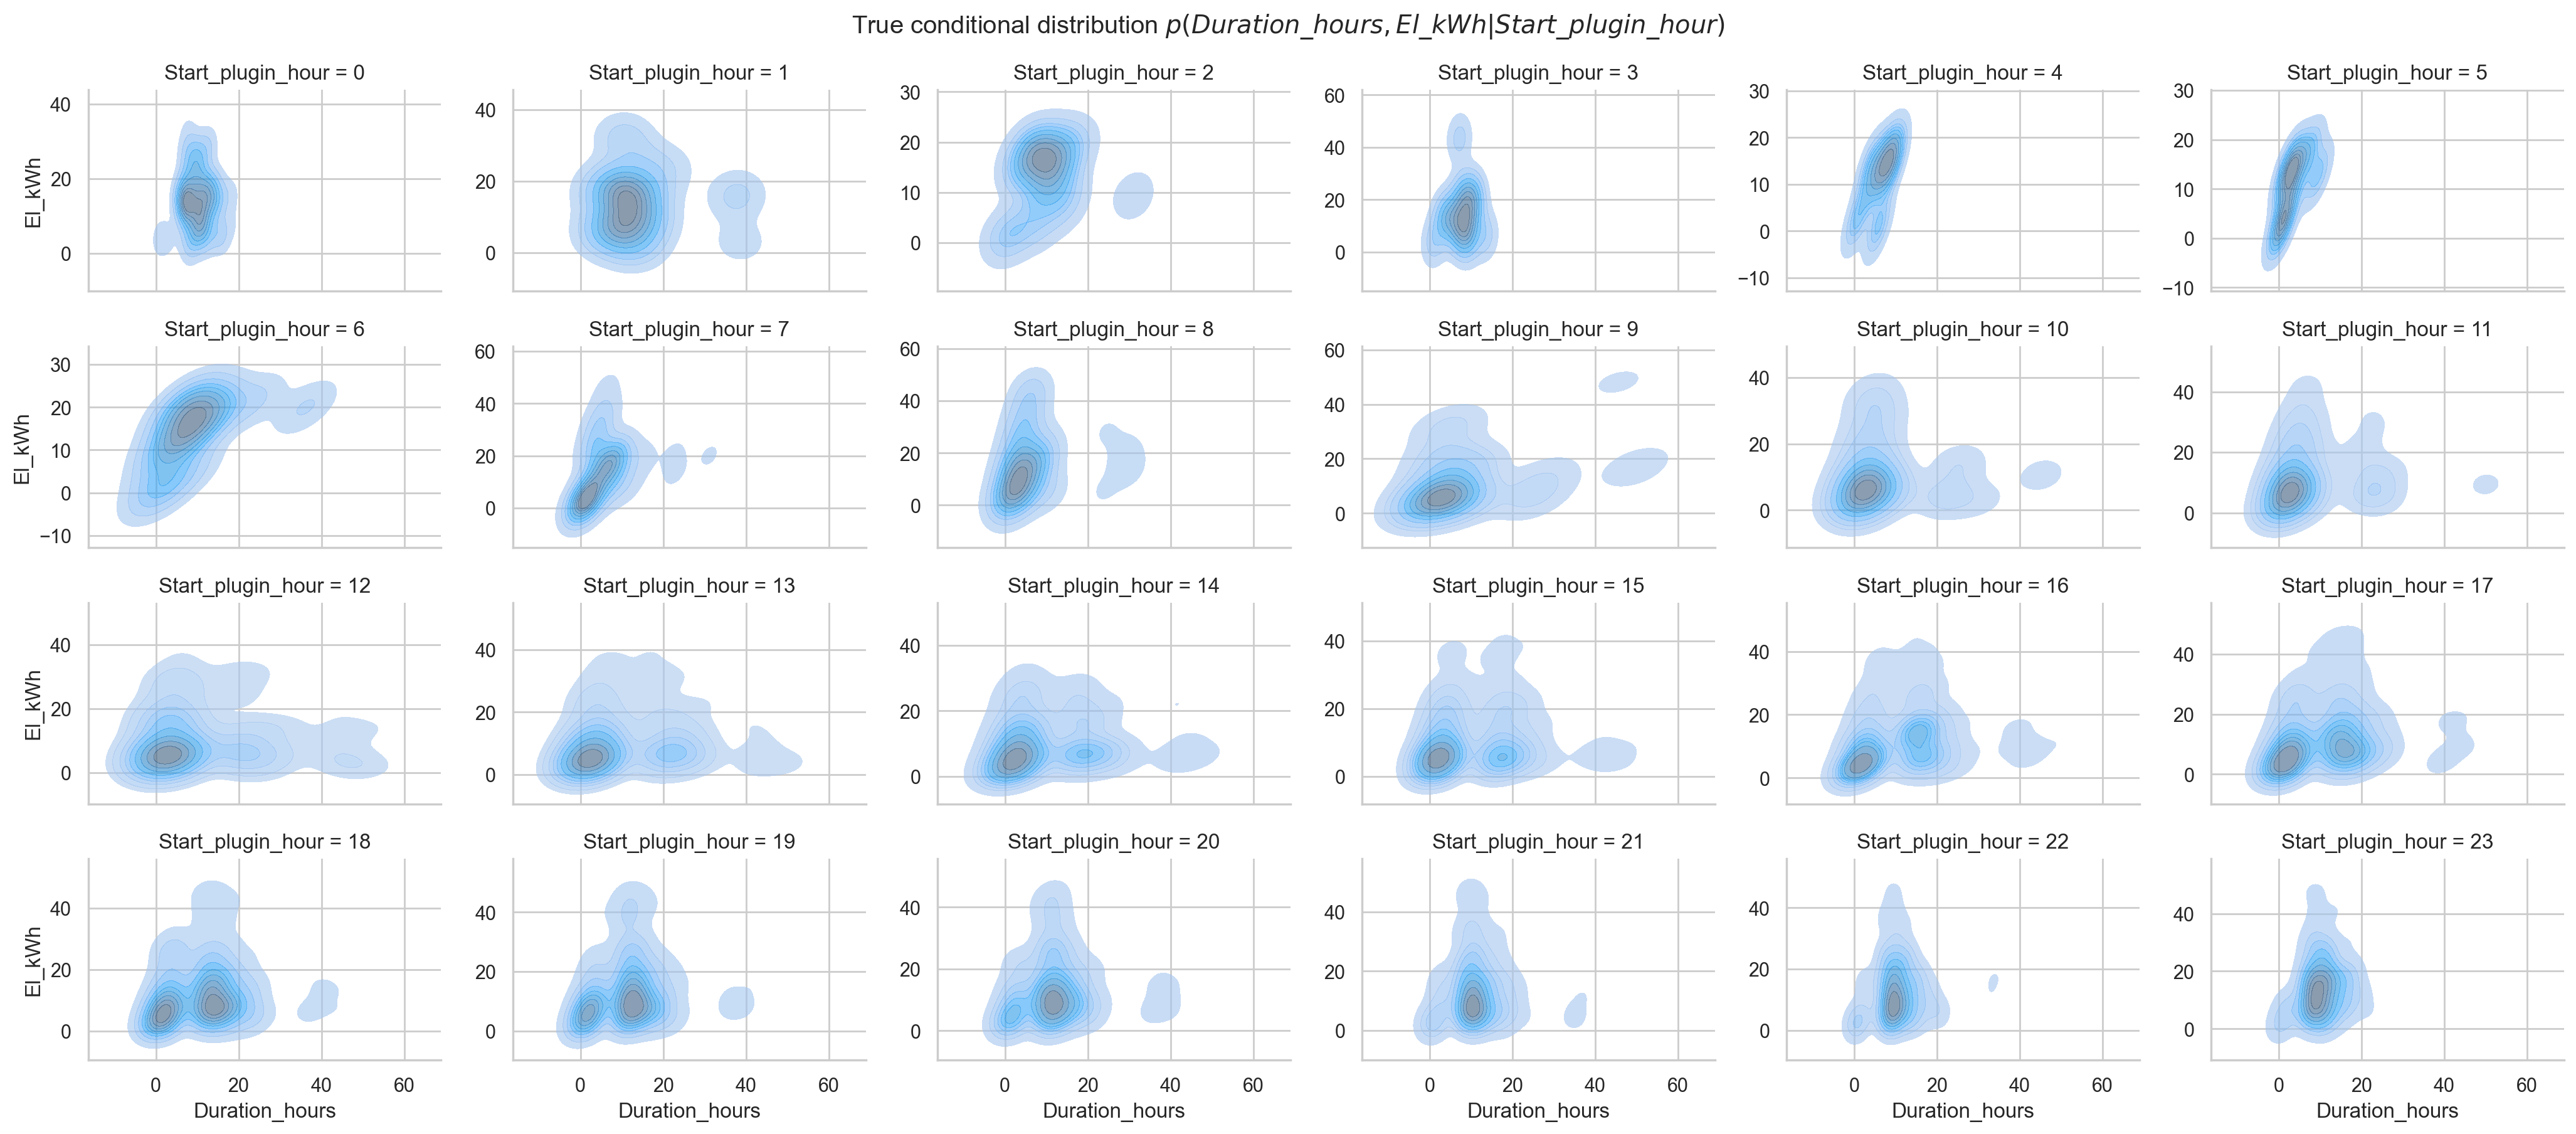

In [24]:
g = sns.FacetGrid(
    density_df,
    col="Start_plugin_hour",
    col_wrap=6,
    height=2.3,
    aspect=1.5,
    sharey=False,
)
g.map(sns.kdeplot, "Duration_hours", "El_kWh", shade=True, alpha=0.6)
g.figure.suptitle(r"True conditional distribution $p(Duration\_hours, El\_kWh | Start\_plugin\_hour)$")
g.figure.tight_layout();

### True conditional distributions colored by GMM cluster

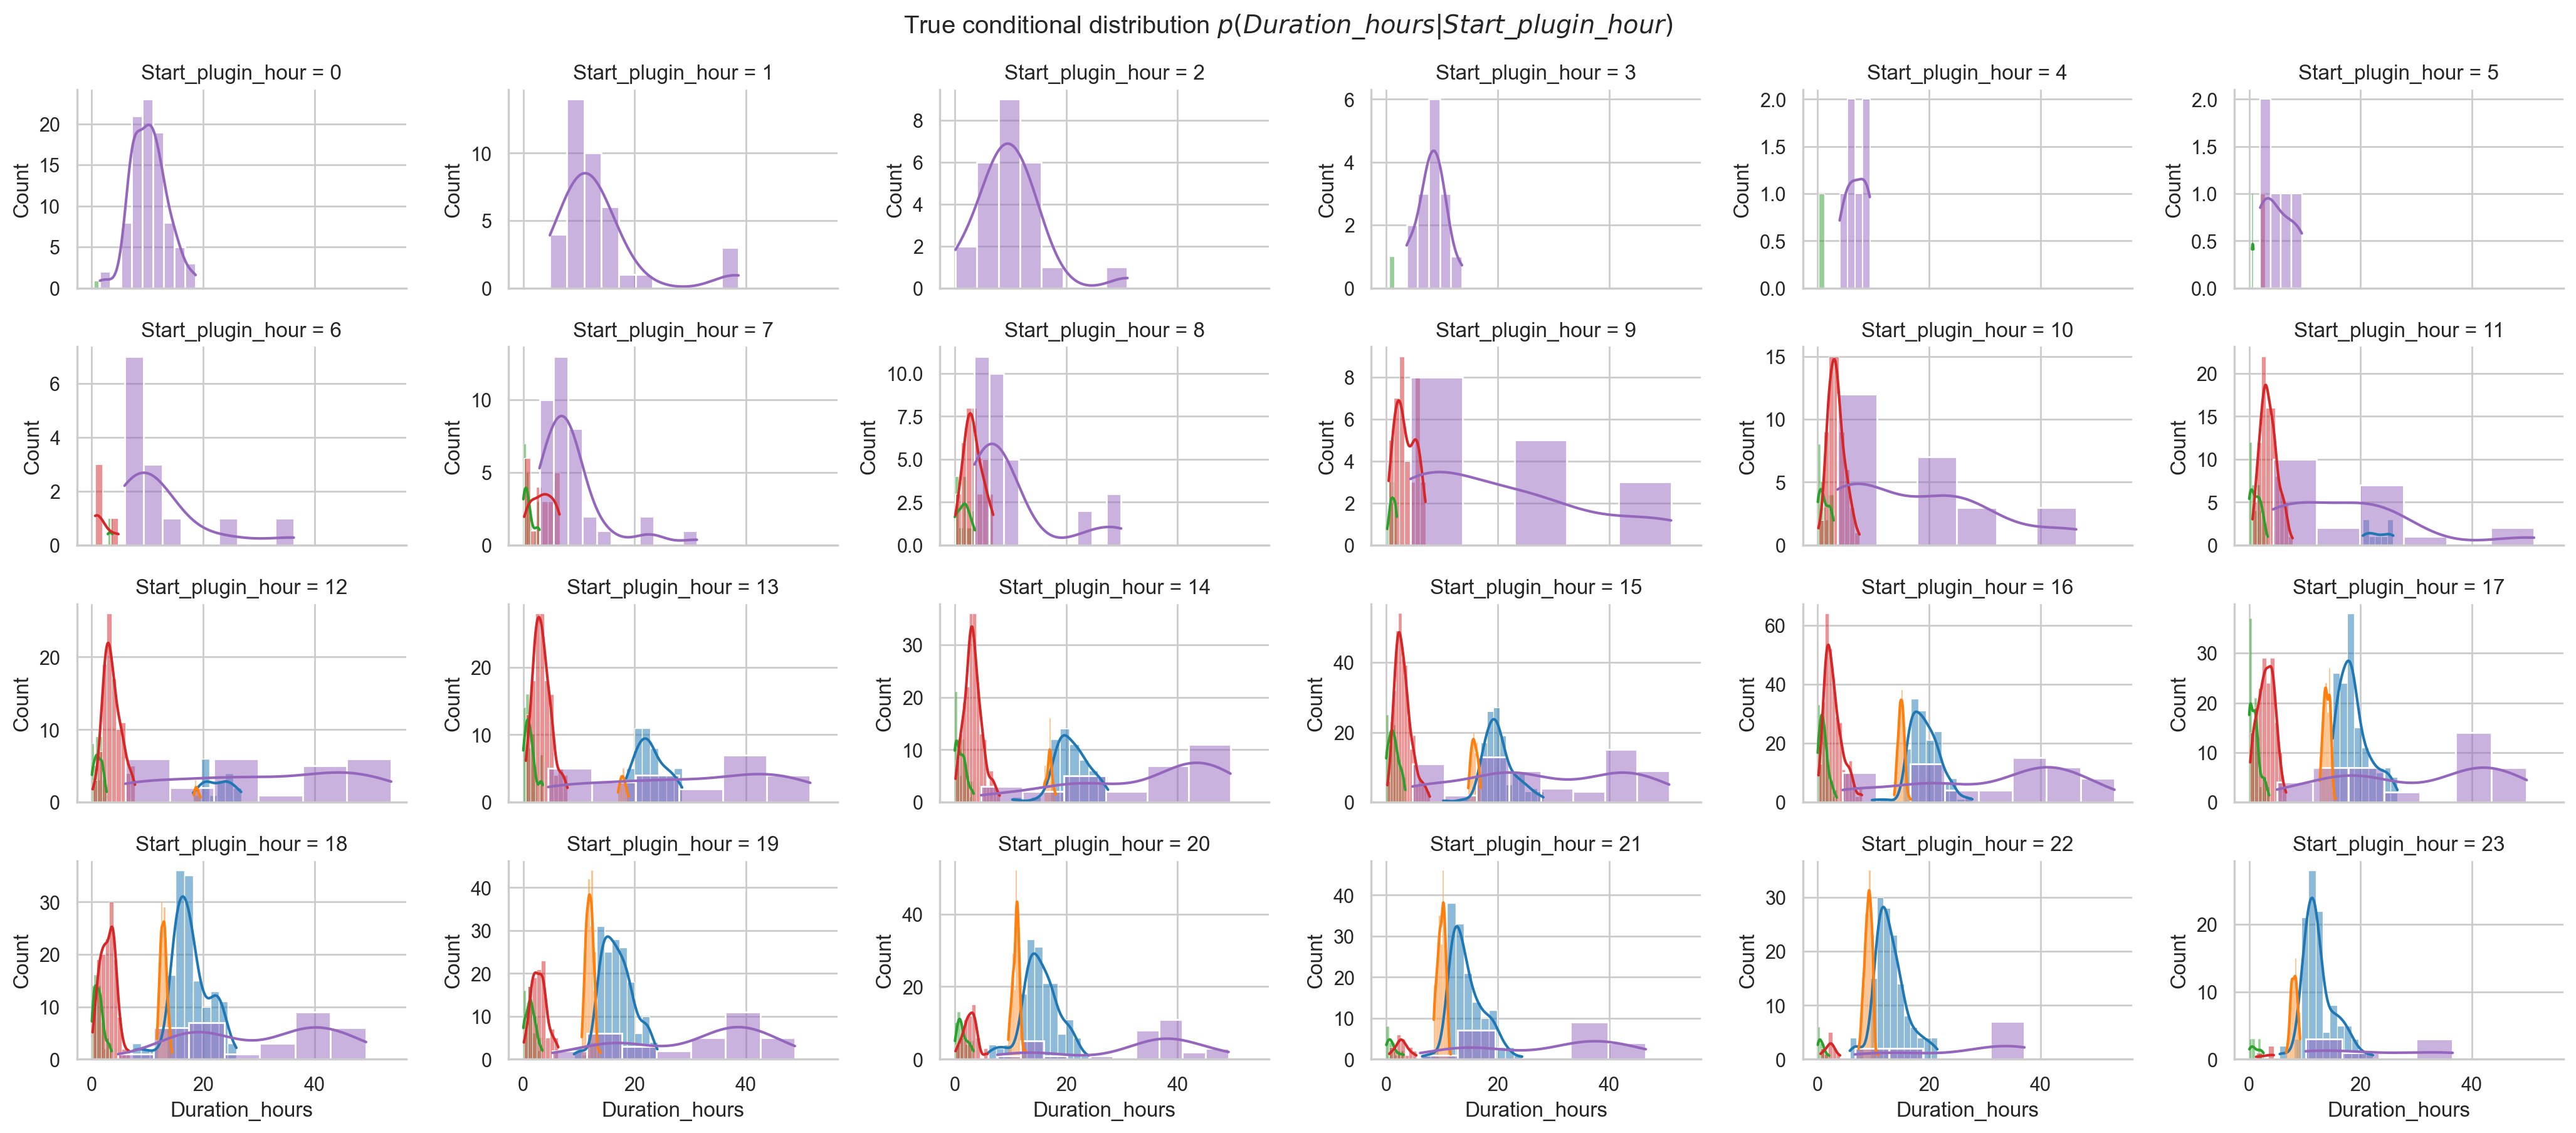

In [25]:
g = sns.FacetGrid(
    density_gmm_df,
    col="Start_plugin_hour",
    hue="cluster",
    col_wrap=6,
    height=2.3,
    aspect=1.5,
    sharey=False,
)
g.map(sns.histplot, "Duration_hours", kde=True)
g.figure.suptitle(r"True conditional distribution $p(Duration\_hours | Start\_plugin\_hour)$")
g.figure.tight_layout();

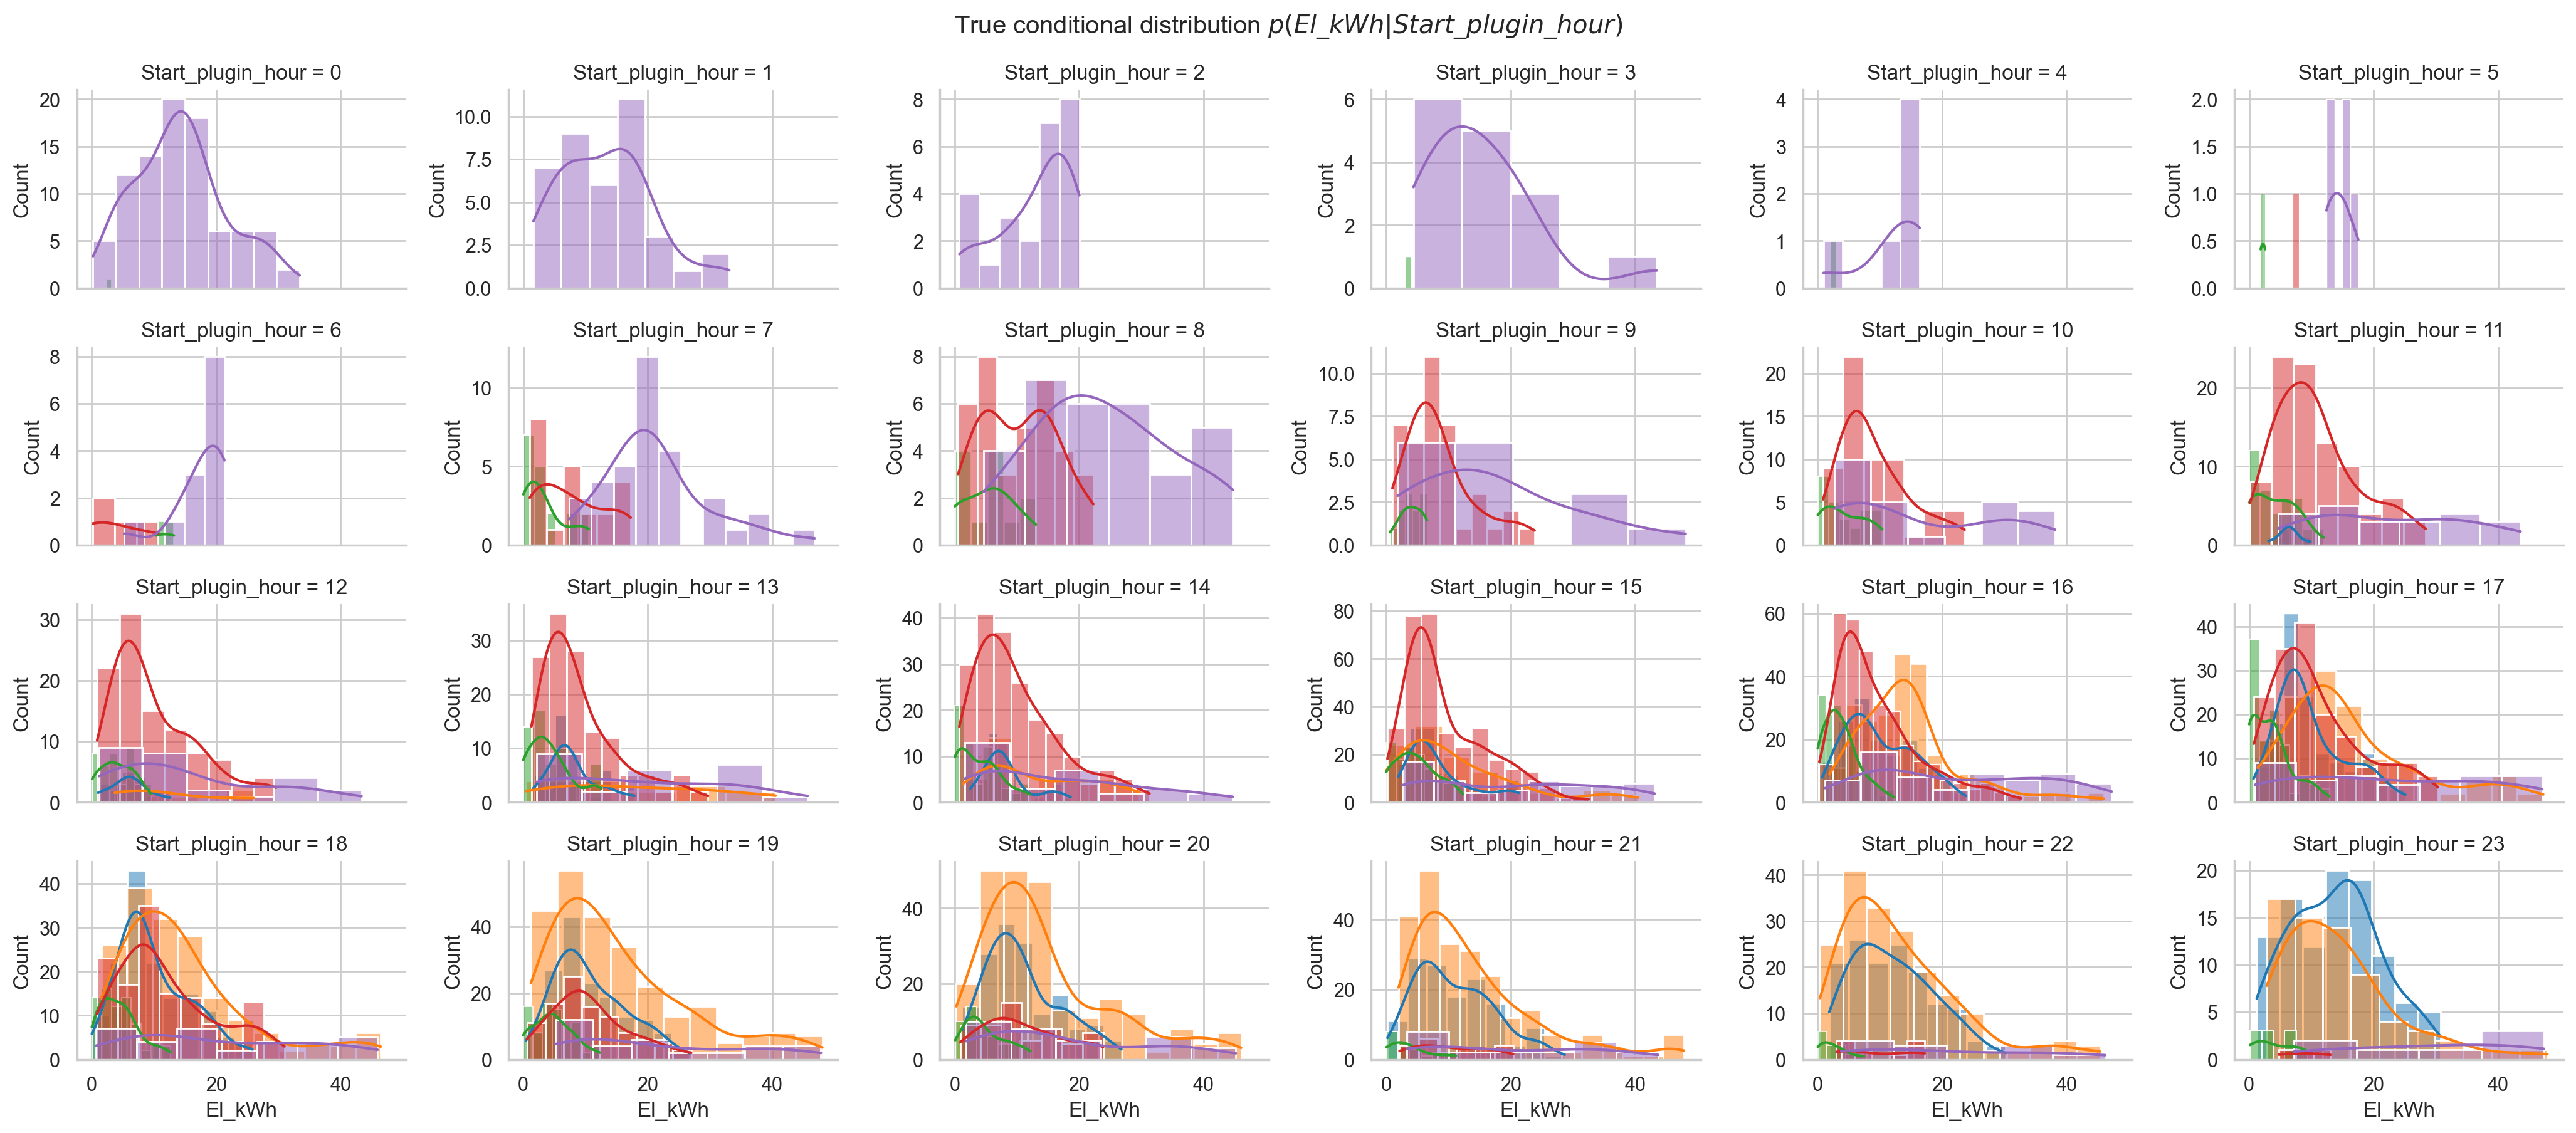

In [26]:
g = sns.FacetGrid(
    density_gmm_df,
    col="Start_plugin_hour",
    hue="cluster",
    col_wrap=6,
    height=2.3,
    aspect=1.5,
    sharey=False,
)
g.map(sns.histplot, "El_kWh", kde=True)
g.figure.suptitle(r"True conditional distribution $p(El\_kWh | Start\_plugin\_hour)$")
g.figure.tight_layout();

### Estimated conditional distributions by GMM
Now, we want to calculate the conditional distribution $p(\text{Duration_hours}, \text{El_kWh} | \text{Start_plugin_hour})$ estimated by the GMM. To do that, we have to derive the conditional distributions for each GMM mixture component. Luckily, the conditional distribution for one variable, given all other variables of a joint multivariate normal distribition is a normal distribution with well defined moments.

Formula to derive the conditional distribution $p(X | Y) \sim \mathcal{N}$ for a joint multivariate normal distribution $p(X, Y) \sim \mathcal{MVN}$ is on Wikipedia: https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions.

In [27]:
class ConditionalGaussianMixture:
    def __init__(self, mvns: npt.NDArray[MultivariateNormal], weights: npt.NDArray[float]):
        self._mvns = mvns
        self._weights = weights

    def partition(self, k):
        for mvn in self._mvns:
            mvn.partition(k)

    def _calc_cond_weights(self, ind, z):
        den_components = np.zeros(len(weights))
        for i in range(len(self._weights)):
            marg_mean, marg_cov = self._mvns[i].marg_dist(1 - ind)
            den_components[i] = multivariate_normal(marg_mean, marg_cov).pdf(z) * weights[i]

        den = np.sum(den_components)

        cond_weights = np.zeros(len(weights))
        for i in range(len(weights)):
            cond_weights[i] = den_components[i] / den

        return cond_weights

    def _select_mixture_component(self, weights):
        acc_weights = [np.sum(weights[:i]) for i in range(1, len(weights) + 1)]
        if not np.isclose(acc_weights[-1], 1):
            raise ValueError("Provided weights for mixture components are invalid. Must sum up to one.")

        r = np.random.uniform(0, 1)
        k = 0
        for i, threshold in enumerate(acc_weights):
            if r < threshold:
                k = i
                break
        return k

    def cond_dist(self, ind, z):
        cond_weights = self._calc_cond_weights(ind, z)
        mixture_index = self._select_mixture_component(cond_weights)
        mixture_component = self._mvns[mixture_index]

        return mixture_component.cond_dist(ind, z)

In [28]:
mvns = np.array([MultivariateNormal(mean, cov) for mean, cov in zip(best_gmm.means_, best_gmm.covariances_)])
weights = np.array(best_gmm.weights_)

In [29]:
cond_gmm = ConditionalGaussianMixture(mvns, weights)
cond_gmm.partition(2)

In [30]:
density_conditional_gen_df = pd.DataFrame()
for hour in range(24):
    len_true_data: int = len(density_df[density_df["Start_plugin_hour"] == hour])
    sample_data = np.zeros((len_true_data, 2), dtype=float)
    for i in range(len_true_data):
        # Get conditional distribition for Duration_hours by fixing Start_plugin_hour = hour
        mean, cov = cond_gmm.cond_dist(0, hour)
        sample = np.random.multivariate_normal(mean, cov, 1).reshape(-1)
        # Sample again if sampled value is smaller or equal to zero
        while sample[0] <= 0 or sample[1] <= 0:
            sample = np.random.multivariate_normal(mean, cov, 1).reshape(-1)
        sample_data[i] = sample
    density_conditional_gen_df = pd.concat(
        [
            density_conditional_gen_df,
            pd.DataFrame({"Duration_hours": sample_data[:, 0], "El_kWh": sample_data[:, 1], "Start_plugin_hour": hour}),
        ]
    )

In [31]:
density_conditional_sample_df_vs_gen_df = pd.concat([density_df, density_conditional_gen_df], axis=0).reset_index(
    drop=True
)
density_conditional_sample_df_vs_gen_df.loc[: len(density_conditional_gen_df), "type"] = "true values"
density_conditional_sample_df_vs_gen_df.loc[len(density_conditional_gen_df) :, "type"] = "generated values"
density_conditional_sample_df_vs_gen_df["type"].value_counts()

true values         6544
generated values    6544
Name: type, dtype: int64

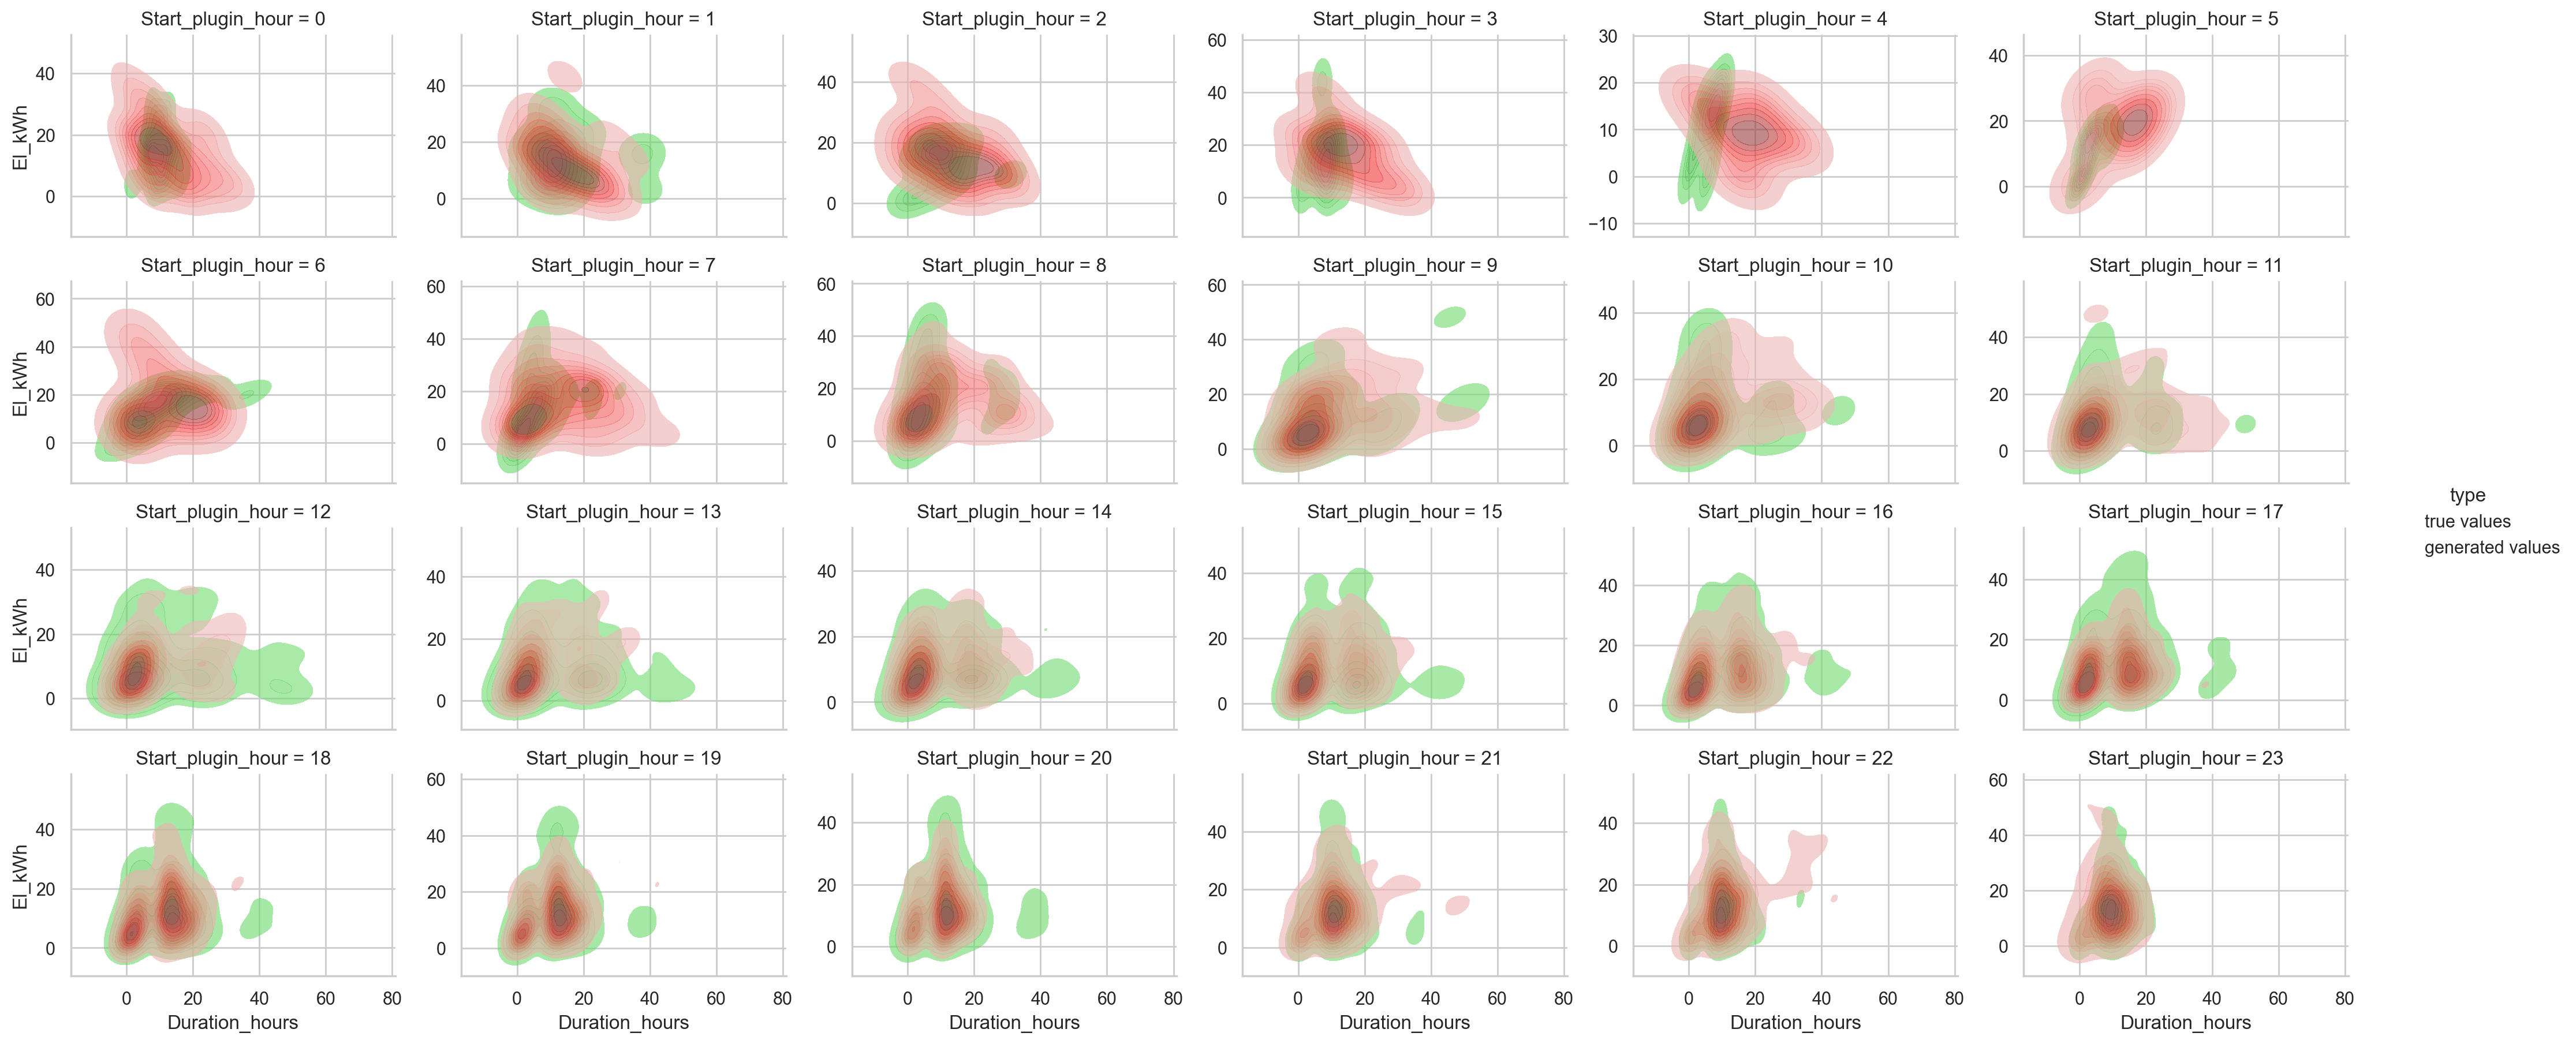

In [32]:
g = sns.FacetGrid(
    density_conditional_sample_df_vs_gen_df,
    hue="type",
    col="Start_plugin_hour",
    col_wrap=6,
    height=2.3,
    aspect=1.5,
    sharey=False,
    palette=["#2ca02c", "#d62728"],
)
g.map(sns.kdeplot, "Duration_hours", "El_kWh", shade=True, alpha=0.6, legend=True)
g.add_legend();